<span style="color: blue;font-weight: bold; font-size: 40px;">PyCaret: ISBSG-CTGAN Data Analysis & Regression </span>


In [1]:
# <span style="color: blue;">ISBSG Data Analysis & Regression</span>


In [2]:
import sys

print(sys.executable)

C:\Users\jdche\.conda\envs\pycaret311\python.exe


In [3]:
# # ISBSG Data Analysis and Regression Modeling
# 
# This notebook performs data cleaning, preprocessing, and regression modeling on the ISBSG dataset.

# ## Setup and Environment Configuration

# Install required packages (uncomment if needed)
#!pip install -r "../requirements.txt" --only-binary=all

In [1]:
# Import basic libraries
import joblib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pycaret
from datetime import datetime
import re
import seaborn as sns
import sklearn
import shap

In [2]:
# Define the foler path
models_folder = '../models'
skeleton_models_folder = '../skeleton_models'
plots_folder = '../plots'
temp_folder = '../temp'
data_folder = '../data'
logs_folder = '../logs'
sample_file = 'sample_clean_a_agile_only_cleaned_no_add.csv'
data_file = 'synthetic_ISBSG2016R1_1_agile_ctgan_generated.csv'

# Identify target column
TARGET_COL = 'project_prf_normalised_work_effort'
print(f"\nTarget variable: '{TARGET_COL}'")


Target variable: 'project_prf_normalised_work_effort'


<a id = 'Index:'></a>

# Table of Content

In this notebook you will apply xxxxxxx


- [Part 1](#part1)- Data Loading and Initial Exploration
- [Part 2](#part2)- Data Cleaning and Preprocessing
- [Part 3](#part3)- Data Profiling
- [Part 4](#part4)- Module Building with PyCaret
- [Part 5](#part5)- Model Preparation
- [Part 6](#part6)- Baseline Modeling and Evaluation
- [Part 7](#part7)- Advanced Modeling and Hyperparameter Tuning
- [Part 8](#part8)- Model Comparison and Selection
- [Part 9](#part9)- End


In [3]:
# Configure timestamp callback for Jupyter cells
from IPython import get_ipython

def setup_timestamp_callback():
    """Setup a timestamp callback for Jupyter cells without clearing existing callbacks."""
    ip = get_ipython()
    if ip is not None:
        # Define timestamp function
        def print_timestamp(*args, **kwargs):
            """Print timestamp after cell execution."""
            print(f"Cell executed at: {datetime.now()}")
        
        # Check if our callback is already registered
        callbacks = ip.events.callbacks.get('post_run_cell', [])
        for cb in callbacks:
            if hasattr(cb, '__name__') and cb.__name__ == 'print_timestamp':
                # Already registered
                return
                
        # Register new callback if not already present
        ip.events.register('post_run_cell', print_timestamp)
        print("Timestamp printing activated.")
    else:
        print("Not running in IPython/Jupyter environment.")

# Setup timestamp callback
setup_timestamp_callback()

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

Timestamp printing activated.
Cell executed at: 2025-06-03 15:39:56.420958


[Back to top](#Index:)

<a id='part1'></a>

# Part 1 -Data Loading and Initial Exploration

This section is dedicated to loading the dataset, performing initial data exploration such as viewing the first few rows, and summarizing the dataset's characteristics, including missing values and basic statistical measures.

In [4]:
# Load the data

from pathlib import Path

print("Loading data...")

file_path = f"{data_folder}/{data_file}"  #should use data_file
file_name_no_ext = Path(file_path).stem                
print(file_name_no_ext)


df = pd.read_csv(file_path)


Loading data...
synthetic_ISBSG2016R1_1_agile_ctgan_generated
Cell executed at: 2025-06-03 15:39:59.442196


# Exploratory Data Analysis

## Data Overview

Dataset shape: (2000, 6)
First 5 rows:


,age,income,category,status,score,region_code
0,71,51950.960,D,pending,31.408690,3.0
1,64,53982.010,C,pending,55.778397,1.0
2,71,51048.082,D,inactive,44.217148,5.0
3,70,56831.960,D,active,60.442863,1.0
4,62,47212.797,D,pending,66.333460,1.0


Last 5 rows:


,age,income,category,status,score,region_code
1995,67,48514.250,B,active,54.998928,1.0
1996,60,49016.016,D,pending,57.354137,1.0
1997,65,49846.324,B,pending,58.900390,3.0
1998,58,52792.176,D,inactive,44.128400,1.0
1999,64,47382.465,C,inactive,65.368450,3.0


## Duplicate Rows

Number of duplicate rows: 0


## Data Types and Memory Usage

,Data Type,Memory Usage (MB)
Index,NaN,0.000126
age,int64,0.015259
category,object,0.112232
income,float64,0.015259
region_code,float64,0.015259
score,float64,0.015259
status,object,0.122343


## Unique Values Per Column

age: 42 unique values
income: 1999 unique values
category: 4 unique values
status: 3 unique values
score: 2000 unique values
region_code: 5 unique values


## Type Conversion Suggestions

Consider converting to 'category' dtype for memory/performance:
['category', 'status']


## Summary Statistics

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,2000.000000,nan,nan,nan,63.143500,6.546475,31.000000,60.000000,64.000000,68.000000,76.000000
income,2000.000000,nan,nan,nan,54212.838390,5263.670401,36826.715000,50724.198250,54748.445000,58187.782750,65400.223000
category,2000,4,D,1098,nan,nan,nan,nan,nan,nan,nan
status,2000,3,pending,1222,nan,nan,nan,nan,nan,nan,nan
score,2000.000000,nan,nan,nan,53.876701,8.729003,26.845947,47.876788,54.316414,60.322595,73.220310
region_code,2000.000000,nan,nan,nan,2.804000,1.450736,1.000000,1.000000,3.000000,4.000000,5.000000


## Missing Values

No missing values in the dataset.


## Distribution of Numerical Features

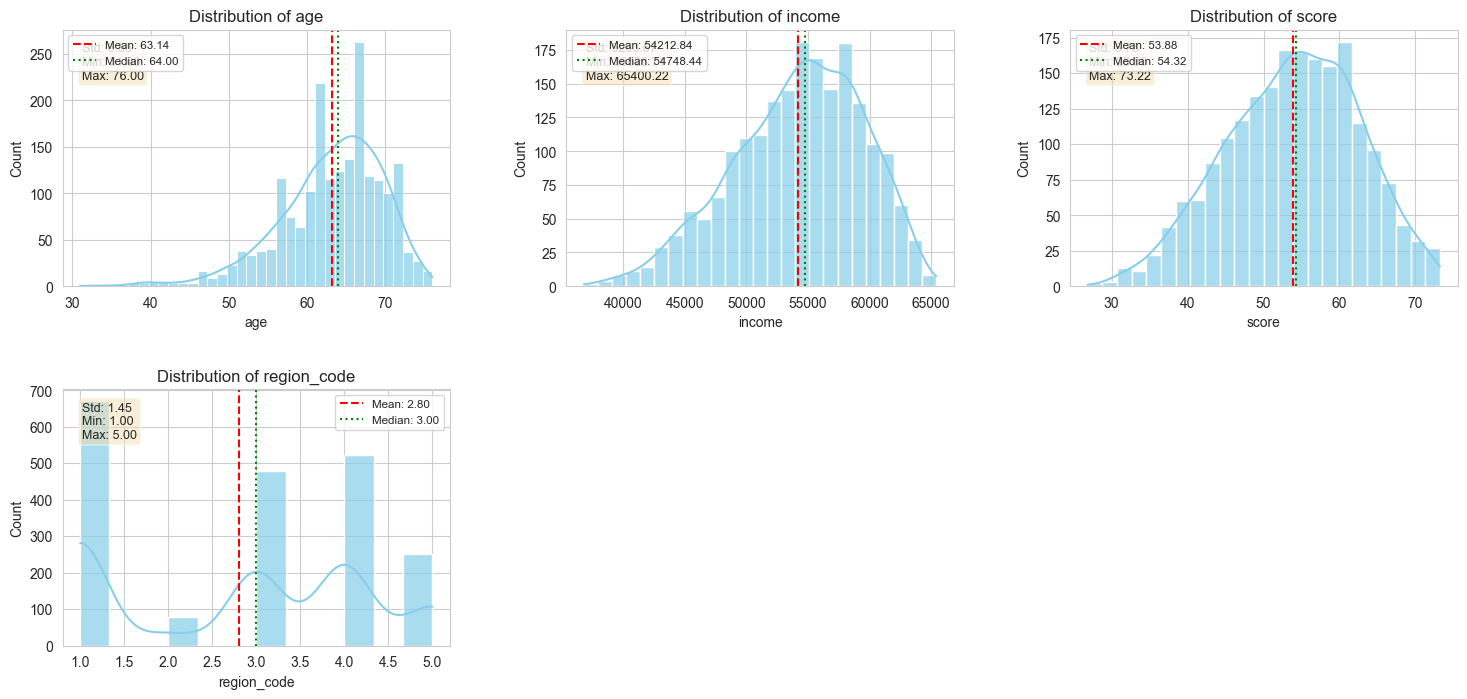

## Correlation Matrix

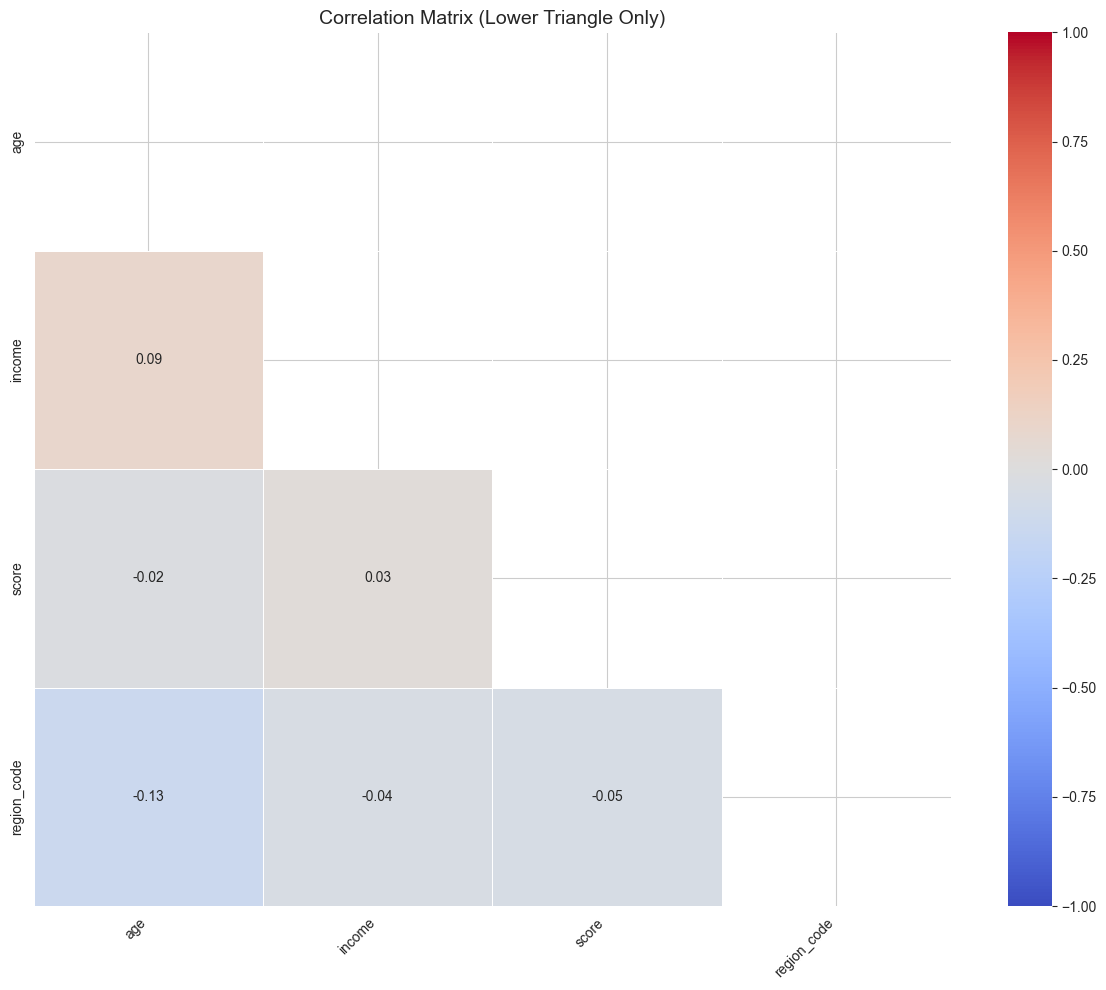

## Categorical Features

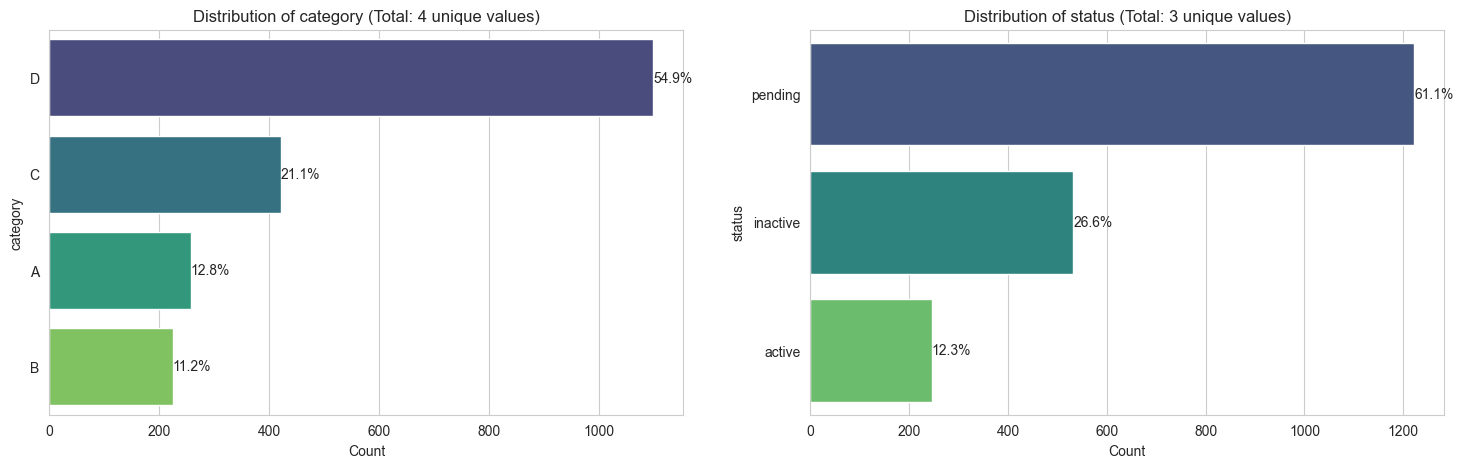

## Categorical-Numerical Relationships

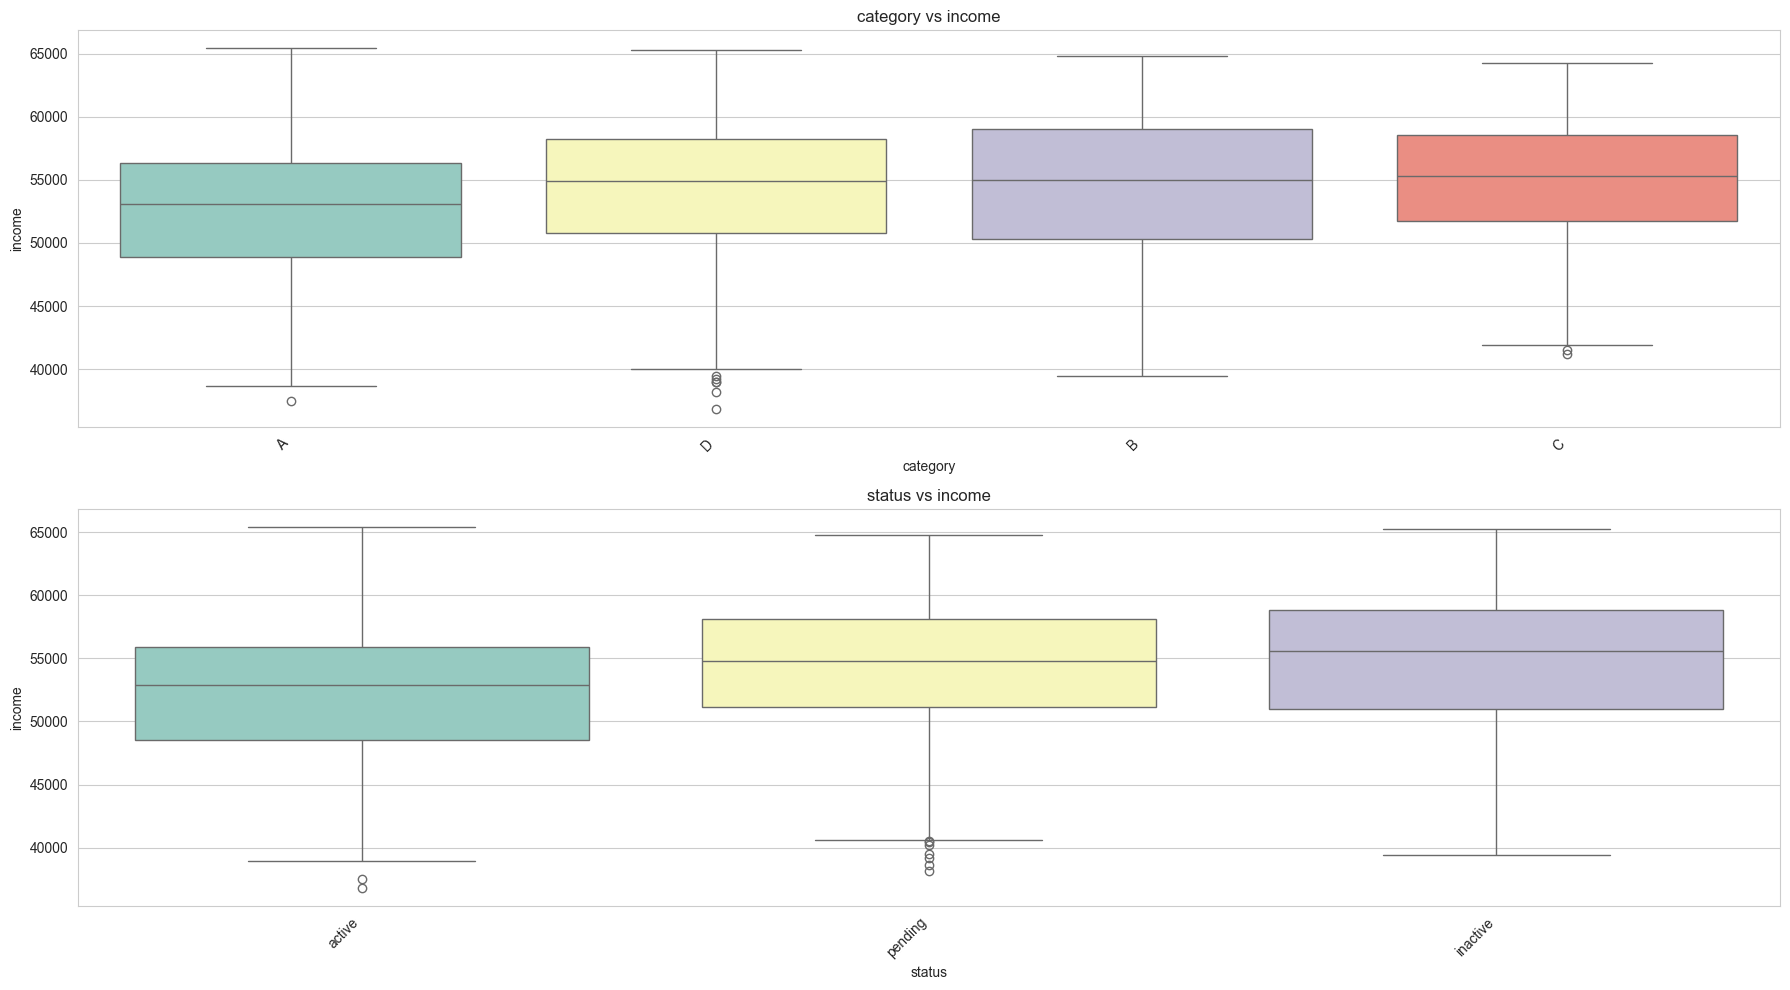

Cell executed at: 2025-06-03 15:40:04.183491


In [5]:
def display_header(text):
    try:
        from IPython.display import display, Markdown
        display(Markdown(f"# {text}"))
    except ImportError:
        print(f"\n=== {text} ===\n")

def display_subheader(text):
    try:
        from IPython.display import display, Markdown
        display(Markdown(f"## {text}"))
    except ImportError:
        print(f"\n-- {text} --\n")

def explore_data(df: pd.DataFrame) -> None:
    """
    Perform exploratory data analysis on the input DataFrame with nicely aligned plots.
    Args:
        df: Input DataFrame
    """
    from IPython.display import display

    display_header("Exploratory Data Analysis")
    
    # Data Overview
    display_subheader("Data Overview")
    print(f"Dataset shape: {df.shape}")
    if df.shape[0] > 20:
        print("First 5 rows:")
        display(df.head())
        print("Last 5 rows:")
        display(df.tail())
    else:
        display(df)
    
    # Duplicate Row Checking
    display_subheader("Duplicate Rows")
    num_duplicates = df.duplicated().sum()
    print(f"Number of duplicate rows: {num_duplicates}")

    # Data Types and Memory Usage
    display_subheader("Data Types and Memory Usage")
    dtype_info = pd.DataFrame({
        'Data Type': df.dtypes,
        'Memory Usage (MB)': df.memory_usage(deep=True) / 1024 / 1024
    })
    display(dtype_info)
    
    # Unique Values Per Column
    display_subheader("Unique Values Per Column")
    for col in df.columns:
        print(f"{col}: {df[col].nunique()} unique values")
    
    # Type Conversion Suggestions
    display_subheader("Type Conversion Suggestions")
    potential_cat = [
        col for col in df.select_dtypes(include=['object']).columns
        if df[col].nunique() < max(30, 0.05*df.shape[0])
    ]
    if potential_cat:
        print("Consider converting to 'category' dtype for memory/performance:")
        print(potential_cat)
    else:
        print("No obvious candidates for 'category' dtype conversion.")
    
    # Summary Statistics
    display_subheader("Summary Statistics")
    try:
        display(df.describe(include='all').T.style.background_gradient(cmap='Blues', axis=1))
    except Exception:
        display(df.describe(include='all').T)
    
    # Missing Values
    display_subheader("Missing Values")
    missing = df.isnull().sum()
    missing_percent = (missing / len(df)) * 100
    missing_info = pd.DataFrame({
        'Missing Values': missing,
        'Percentage (%)': missing_percent.round(2)
    })
    if missing.sum() > 0:
        display(missing_info[missing_info['Missing Values'] > 0]
                .sort_values('Missing Values', ascending=False)
                .style.background_gradient(cmap='Reds'))
        # Visualize missing values
        plt.figure(figsize=(12, 6))
        cols_with_missing = missing_info[missing_info['Missing Values'] > 0].index
        if len(cols_with_missing) > 0:
            sns.heatmap(df[cols_with_missing].isnull(), 
                        cmap='viridis', 
                        yticklabels=False, 
                        cbar_kws={'label': 'Missing Values'})
            plt.title('Missing Value Patterns')
            plt.tight_layout()
            plt.show()
    else:
        print("No missing values in the dataset.")
    
    # Numerical Distributions
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    if len(numerical_cols) > 0:
        display_subheader("Distribution of Numerical Features")
        sample_cols = numerical_cols[:min(12, len(numerical_cols))]
        num_cols = len(sample_cols)
        num_rows = (num_cols + 2) // 3  # 3 plots per row, rounded up
        fig = plt.figure(figsize=(18, num_rows * 4))
        grid = plt.GridSpec(num_rows, 3, figure=fig, hspace=0.4, wspace=0.3)
        for i, col in enumerate(sample_cols):
            row, col_pos = divmod(i, 3)
            ax = fig.add_subplot(grid[row, col_pos])
            sns.histplot(df[col].dropna(), kde=True, ax=ax, color='skyblue', alpha=0.7)
            mean_val = df[col].mean()
            median_val = df[col].median()
            ax.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
            ax.axvline(median_val, color='green', linestyle=':', label=f'Median: {median_val:.2f}')
            stats_text = (f"Std: {df[col].std():.2f}\n"
                          f"Min: {df[col].min():.2f}\n"
                          f"Max: {df[col].max():.2f}")
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
            ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=9,
                    verticalalignment='top', bbox=props)
            ax.set_title(f'Distribution of {col}')
            ax.legend(fontsize='small')
        plt.tight_layout()
        plt.show()
        # Correlation matrix and top correlations
        if len(numerical_cols) > 1:
            display_subheader("Correlation Matrix")
            corr = df[numerical_cols].corr().round(2)
            mask = np.triu(np.ones_like(corr, dtype=bool))
            plt.figure(figsize=(12, 10))
            sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', 
                        fmt=".2f", linewidths=0.5, vmin=-1, vmax=1, 
                        annot_kws={"size": 10})
            plt.title('Correlation Matrix (Lower Triangle Only)', fontsize=14)
            plt.xticks(rotation=45, ha='right', fontsize=10)
            plt.yticks(fontsize=10)
            plt.tight_layout()
            plt.show()
            # Top correlations
            if len(numerical_cols) > 5:
                corr_unstack = corr.unstack()
                corr_abs = corr_unstack.apply(abs)
                corr_abs = corr_abs[corr_abs < 1.0]
                highest_corrs = corr_abs.sort_values(ascending=False).head(15)
                display_subheader("Top Correlations")
                for (col1, col2), corr_val in highest_corrs.items():
                    actual_val = corr.loc[col1, col2]
                    print(f"{col1} — {col2}: {actual_val:.2f}")
                pairs_to_plot = [(idx[0], idx[1]) for idx in highest_corrs.index][:6]
                if pairs_to_plot:
                    fig = plt.figure(figsize=(18, 12))
                    grid = plt.GridSpec(2, 3, figure=fig, hspace=0.3, wspace=0.3)
                    for i, (col1, col2) in enumerate(pairs_to_plot):
                        row, col_pos = divmod(i, 3)
                        ax = fig.add_subplot(grid[row, col_pos])
                        sns.regplot(x=df[col1], y=df[col2], ax=ax, scatter_kws={'alpha':0.5})
                        r_value = df[col1].corr(df[col2])
                        ax.set_title(f'{col1} vs {col2} (r = {r_value:.2f})')
                    plt.tight_layout()
                    plt.show()
    # Categorical columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    if len(categorical_cols) > 0:
        display_subheader("Categorical Features")
        sample_cat_cols = categorical_cols[:min(6, len(categorical_cols))]
        num_cat_cols = len(sample_cat_cols)
        num_cat_rows = (num_cat_cols + 1) // 2
        fig = plt.figure(figsize=(18, num_cat_rows * 5))
        grid = plt.GridSpec(num_cat_rows, 2, figure=fig, hspace=0.4, wspace=0.2)
        for i, col in enumerate(sample_cat_cols):
            row, col_pos = divmod(i, 2)
            ax = fig.add_subplot(grid[row, col_pos])
            value_counts = df[col].value_counts().sort_values(ascending=False)
            top_n = min(10, len(value_counts))
            if len(value_counts) > top_n:
                top_values = value_counts.head(top_n-1)
                other_count = value_counts.iloc[top_n-1:].sum()
                plot_data = pd.concat([top_values, pd.Series({'Other': other_count})])
            else:
                plot_data = value_counts
            sns.barplot(x=plot_data.values, y=plot_data.index, ax=ax, palette='viridis')
            ax.set_title(f'Distribution of {col} (Total: {len(value_counts)} unique values)')
            ax.set_xlabel('Count')
            total = plot_data.sum()
            for j, v in enumerate(plot_data.values):
                percentage = v / total * 100
                ax.text(v + 0.1, j, f'{percentage:.1f}%', va='center')
        plt.tight_layout()
        plt.show()
        # Categorical-numerical boxplots
        if numerical_cols and len(categorical_cols) > 0:
            display_subheader("Categorical-Numerical Relationships")
            numerical_variances = df[numerical_cols].var()
            target_numerical = numerical_variances.idxmax()
            sample_cat_for_box = [col for col in categorical_cols 
                                  if df[col].nunique() <= 15][:4]
            if sample_cat_for_box:
                fig = plt.figure(figsize=(18, 5 * len(sample_cat_for_box)))
                for i, cat_col in enumerate(sample_cat_for_box):
                    ax = fig.add_subplot(len(sample_cat_for_box), 1, i+1)
                    order = df.groupby(cat_col)[target_numerical].median().sort_values().index
                    sns.boxplot(x=cat_col, y=target_numerical, data=df, ax=ax, 
                                order=order, palette='Set3')
                    ax.set_title(f'{cat_col} vs {target_numerical}')
                    ax.set_xlabel(cat_col)
                    ax.set_ylabel(target_numerical)
                    plt.xticks(rotation=45, ha='right')
                plt.tight_layout()
                plt.show()

# Exploratory Data Analysis
explore_data(df)


[Back to top](#Index:)

<a id='#part2'></a>

# Part 2 - Data Cleaning and Preprocessing

Here, data cleaning tasks like handling missing values and providing a detailed summary of each feature, including its type, number of unique values, and a preview of unique values, are performed.

In [6]:
# Analyse missing values
print("\nAnalysing missing values...")
missing_pct = df.isnull().mean() * 100
missing_sorted = missing_pct.sort_values(ascending=False)
print("Top 10 columns with highest missing percentages:")
print(missing_sorted)


Analysing missing values...
Top 10 columns with highest missing percentages:
age            0.0
income         0.0
category       0.0
status         0.0
score          0.0
region_code    0.0
dtype: float64
Cell executed at: 2025-06-03 15:40:34.682808


In [7]:
# Identify columns with high missing values (>70%)
high_missing_cols = missing_pct[missing_pct > 70].index.tolist()
print(f"\nColumns with >70% missing values ({len(high_missing_cols)} columns):")
for col in high_missing_cols[:]:  # Show first 5
    print(f"  - {col}: {missing_pct[col]:.2f}% missing")
if len(high_missing_cols) > 5:
    print(f"  - ... and {len(high_missing_cols) - 5} more columns")

print(f"Columns are: {list(df.columns)}")


Columns with >70% missing values (0 columns):
Columns are: ['age', 'income', 'category', 'status', 'score', 'region_code']
Cell executed at: 2025-06-03 15:41:05.286152


In [12]:
# Create a clean dataframe by dropping high-missing columns

cols_to_keep = ['project_prf_year_of_project', 'external_eef_industry_sector', 'tech_tf_primary_programming_language', 
                'project_prf_functional_size', 'project_prf_normalised_work_effort', 'project_prf_team_size_group', 
                'project_prf_max_team_size', 'process_pmf_development_methodologies', 'process_pmf_docs', 'tech_tf_client_roles', 
                'tech_tf_server_roles', 'tech_tf_tools_used', 'project_prf_application_group_business_application', 
                'project_prf_application_group_infrastructure_software', 'project_prf_application_group_mathematically_intensive_application', 
                'project_prf_application_group_nan', 'project_prf_application_group_real_time_application', 
                'tech_tf_clientserver_description_browser_server_architecture', 'tech_tf_clientserver_description_client_server', 
                'tech_tf_clientserver_description_client_presentation', 'tech_tf_clientserver_description_client_presentation_processing', 
                'tech_tf_clientserver_description_client_server_architecture', 'tech_tf_clientserver_description_client_server_architecture_p2p', 
                'tech_tf_clientserver_description_nan', 'tech_tf_clientserver_description_server_processing', 
                'tech_tf_clientserver_description_stand_alone', 'tech_tf_clientserver_description_web', 'project_prf_development_type_enhancement', 
                'project_prf_development_type_new_development', 'project_prf_development_type_other', 'project_prf_development_type_poc', 
                'project_prf_development_type_porting', 'project_prf_development_type_re_development', 'tech_tf_development_platform_mf', 
                'tech_tf_development_platform_mr', 'tech_tf_development_platform_multi', 'tech_tf_development_platform_nan', 
                'tech_tf_development_platform_pc', 'tech_tf_development_platform_proprietary', 'tech_tf_language_type_2gl', 
                'tech_tf_language_type_3gl', 'tech_tf_language_type_4gl', 'tech_tf_language_type_5gl', 'tech_tf_language_type_apg', 
                'tech_tf_language_type_nan', 'project_prf_relative_size_l', 'project_prf_relative_size_m1', 'project_prf_relative_size_m2', 
                'project_prf_relative_size_nan', 'project_prf_relative_size_s', 'project_prf_relative_size_xl', 'project_prf_relative_size_xs', 
                'project_prf_relative_size_xxl', 'project_prf_relative_size_xxs', 'project_prf_case_tool_used_don_t_know', 
                'project_prf_case_tool_used_nan', 'project_prf_case_tool_used_no', 'project_prf_case_tool_used_yes', 
                'process_pmf_prototyping_used_nan', 'process_pmf_prototyping_used_yes', 'tech_tf_architecture_client_server', 
                'tech_tf_architecture_multi_tier', 'tech_tf_architecture_multi_tier_with_web_interface', 
                'tech_tf_architecture_multi_tier_with_web_public_interface', 'tech_tf_architecture_nan', 'tech_tf_architecture_stand_alone', 
                'tech_tf_architecture_standalone', 'tech_tf_client_server_don_t_know', 'tech_tf_client_server_nan', 'tech_tf_client_server_no', 
                'tech_tf_client_server_yes', 'tech_tf_type_of_server_back_end', 'tech_tf_type_of_server_client_server', 
                'tech_tf_type_of_server_lan_based', 'tech_tf_type_of_server_mainframe', 
                'tech_tf_type_of_server_multi_tier_with_web_public_interface', 'tech_tf_type_of_server_nan', 'tech_tf_type_of_server_standalone', 
                'tech_tf_type_of_server_unix', 'tech_tf_type_of_server_webserver', 'tech_tf_web_development_nan', 'tech_tf_web_development_web', 
                'tech_tf_dbms_used_nan', 'tech_tf_dbms_used_no', 'tech_tf_dbms_used_yes', 'people_prf_project_user_involvement_best', 
                'people_prf_project_user_involvement_don_t_know', 'people_prf_project_user_involvement_low', 
                'people_prf_project_user_involvement_nan', 'people_prf_project_user_involvement_no', 'people_prf_project_user_involvement_yes', 
                'external_eef_organisation_type_top_insurance', 'external_eef_organisation_type_top_medical and health care', 
                'external_eef_organisation_type_top_manufacturing', 'external_eef_organisation_type_top_telecommunications', 
                'external_eef_organisation_type_top_government', 'external_eef_organisation_type_top_nan', 
                'external_eef_organisation_type_top_communications', 'external_eef_organisation_type_top_banking', 
                'external_eef_organisation_type_top_computers & software', 'external_eef_organisation_type_top_defence', 
                'external_eef_organisation_type_top_public administration', 'external_eef_organisation_type_top_aerospace / automotive', 
                'external_eef_organisation_type_top_transport & storage', 
                'external_eef_organisation_type_top_financial, property & business services', 
                'external_eef_organisation_type_top_education institution', 'external_eef_organisation_type_top_community services', 
                'external_eef_organisation_type_top_electricity, gas, water', 'external_eef_organisation_type_top_logistics', 
                'external_eef_organisation_type_top_wholesale & retail trade', 'external_eef_organisation_type_top_telecommunication', 
                'external_eef_organisation_type_other', 'project_prf_application_type_top_financial transaction process/accounting', 
                'project_prf_application_type_top_not recorded', 'project_prf_application_type_top_nan', 'project_prf_application_type_top_unknown', 
                'project_prf_application_type_top_customer relationship management', 'project_prf_application_type_top_relatively complex application',
                'project_prf_application_type_top_workflow support & management', 'project_prf_application_type_top_business application', 
                'project_prf_application_type_top_embedded system/real_time application', 'project_prf_application_type_top_online. esales', 
                'project_prf_application_type_top_management of licences and permits', 
                'project_prf_application_type_top_online analysis and reporting', 
                'project_prf_application_type_top_catalogue/register of things or events', 
                'project_prf_application_type_top_software for machine control', 'project_prf_application_type_top_document management', 
                'project_prf_application_type_top_electronic data interchange', 'project_prf_application_type_top_management information system', 
                'project_prf_application_type_top_data warehouse system', 'project_prf_application_type_top_stock control & order processing', 
                'project_prf_application_type_top_management or performance reporting', 'project_prf_application_type_other', 
                'tech_tf_clientserver_description', 'project_prf_development_type_not_defined', 'tech_tf_development_platform_hand_held', 
                'project_prf_relative_size_xxxl', 'tech_tf_architecture_multi_tier_client_server', 'tech_tf_client_server_not_applicable', 
                'tech_tf_type_of_server_proprietary_midrange', 'project_prf_application_type_top_transaction/production system', 
                'project_prf_application_type_top_financial application area', 'project_prf_application_type_top_client-server', 
                'project_prf_application_type_top_customer billing/relationship management']

# Filter high_missing_cols to remove any you want to keep
final_high_missing_cols = [col for col in high_missing_cols if col not in cols_to_keep]


df_clean = df.drop(columns=final_high_missing_cols)
print(f"\nData shape after dropping high-missing columns: {df_clean.shape}")
print(f"\nHigh missing columns got dropped are: {final_high_missing_cols}")

# Numerical columns
num_cols = df_clean.select_dtypes(include=['number']).columns.tolist()
print("\nNumerical columns:")
print(num_cols)

# Categorical columns (object or category dtype)
cat_cols = df_clean.select_dtypes(include=['object', 'category']).columns.tolist()
print("\nCategorical columns:")
print(cat_cols)




Data shape after dropping high-missing columns: (10000, 158)

High missing columns got dropped are: ['project_prf_cost_currency']

Numerical columns:
['isbsg_project_id', 'project_prf_year_of_project', 'project_prf_functional_size', 'project_prf_normalised_work_effort_level_1', 'project_prf_normalised_work_effort', 'project_prf_normalised_level_1_pdr_ufp', 'project_prf_normalised_pdr_ufp', 'project_prf_speed_of_delivery', 'project_prf_project_elapsed_time', 'project_prf_max_team_size', 'process_pmf_docs', 'tech_tf_tools_used', 'project_prf_application_group_business_application', 'project_prf_application_group_infrastructure_software', 'project_prf_application_group_mathematically_intensive_application', 'project_prf_application_group_nan', 'project_prf_application_group_real_time_application', 'tech_tf_clientserver_description_browser_server_architecture', 'tech_tf_clientserver_description_client_server', 'tech_tf_clientserver_description_client_presentation', 'tech_tf_clientserver_d

In [26]:
# Convert the column to numeric (invalid values become NaN)
df_clean['tech_tf_development_platform_hand_held'] = pd.to_numeric(
    df_clean['tech_tf_development_platform_hand_held'],
    errors='coerce'  # This replaces invalid parsing with NaN
)

Cell executed at: 2025-06-03 14:33:10.746406


In [27]:
# Handle remaining missing values
print("\nHandling remaining missing values...")


Handling remaining missing values...
Cell executed at: 2025-06-03 14:33:12.068473


In [28]:
# Fill missing values in categorical columns with "Missing"
cat_cols = df_clean.select_dtypes(include=['object', 'category']).columns
for col in cat_cols:
    df_clean[col].fillna('Missing', inplace=True)

print(cat_cols)

Index(['external_eef_industry_sector', 'tech_tf_primary_programming_language',
       'project_prf_team_size_group', 'process_pmf_development_methodologies',
       'tech_tf_client_roles', 'tech_tf_server_roles',
       'tech_tf_clientserver_description'],
      dtype='object')
Cell executed at: 2025-06-03 14:33:14.431028


In [29]:
# Check remaining missing values
remaining_missing = df_clean.isnull().sum()
remaining_missing_count = sum(remaining_missing > 0)
print(f"\nColumns with remaining missing values: {remaining_missing_count}")
if remaining_missing_count > 0:
    print("Top columns with missing values:")
    print(remaining_missing[remaining_missing > 0].sort_values(ascending=False))


Columns with remaining missing values: 19
Top columns with missing values:
project_prf_application_type_top_transaction/production system               9861
project_prf_application_type_top_financial application area                  9812
project_prf_application_type_top_client-server                               9804
project_prf_application_type_top_customer billing/relationship management    9780
tech_tf_development_platform_hand_held                                        353
project_prf_application_type_top_management of licences and permits           269
tech_tf_clientserver_description_client_presentation_processing               227
project_prf_application_type_top_data warehouse system                        215
project_prf_application_type_top_software for machine control                 208
tech_tf_clientserver_description_stand_alone                                  207
project_prf_application_type_top_management or performance reporting          201
tech_tf_clientserver_d

In [30]:
print(df_clean.columns.tolist())


['isbsg_project_id', 'project_prf_year_of_project', 'external_eef_industry_sector', 'tech_tf_primary_programming_language', 'project_prf_functional_size', 'project_prf_normalised_work_effort_level_1', 'project_prf_normalised_work_effort', 'project_prf_normalised_level_1_pdr_ufp', 'project_prf_normalised_pdr_ufp', 'project_prf_speed_of_delivery', 'project_prf_project_elapsed_time', 'project_prf_team_size_group', 'project_prf_max_team_size', 'process_pmf_development_methodologies', 'process_pmf_docs', 'tech_tf_client_roles', 'tech_tf_server_roles', 'tech_tf_tools_used', 'project_prf_application_group_business_application', 'project_prf_application_group_infrastructure_software', 'project_prf_application_group_mathematically_intensive_application', 'project_prf_application_group_nan', 'project_prf_application_group_real_time_application', 'tech_tf_clientserver_description_browser_server_architecture', 'tech_tf_clientserver_description_client_server', 'tech_tf_clientserver_description_clie

In [31]:
# Verify target variable
print(f"\nTarget variable '{TARGET_COL}' summary:")
print(f"Unique values: {df_clean[TARGET_COL].nunique()}")
print(f"Missing values: {df_clean[TARGET_COL].isnull().sum()}")
print(f"Top value counts:")
print(df_clean[TARGET_COL].value_counts().head())



Target variable 'project_prf_normalised_work_effort' summary:
Unique values: 5738
Missing values: 0
Top value counts:
project_prf_normalised_work_effort
2    52
3    40
4    28
5    26
7    24
Name: count, dtype: int64
Cell executed at: 2025-06-03 14:33:30.336414


In [32]:
# Check for infinite values
inf_check = np.isinf(df_clean.select_dtypes(include=[np.number])).sum().sum()
print(f"\nNumber of infinite values: {inf_check}")


Number of infinite values: 0
Cell executed at: 2025-06-03 14:33:31.138665


In [33]:
# Save cleaned data

file_name_no_ext

df_clean.to_csv(f"{data_folder}/{file_name_no_ext}_droppedcols.csv", index=False)
print(f'{data_folder}/{file_name_no_ext}_droppedcols.csv')


../data/synthetic_ISBSG2016R1_1_agile_SDV_generated_droppedcols.csv
Cell executed at: 2025-06-03 14:33:34.536025


[Back to top](#Index:)

<a id='part3'></a>

# Part 3 - Feature Engineering and Selection

Involves creating or selecting specific features for the model based on insights from EDA, including handling categorical variables and reducing dimensionality if necessary.

In [34]:
# Identify categorical columns and check cardinality
print("\nCategorical columns and their cardinality:")
cat_cols = df_clean.select_dtypes(include=['object', 'category']).columns.tolist()
for col in cat_cols[:5]:  # Show first 5
    print(f"  {col}: {df_clean[col].nunique()} unique values")
if len(cat_cols) > 5:
    print(f"  ... and {len(cat_cols) - 5} more columns")


Categorical columns and their cardinality:
  external_eef_industry_sector: 17 unique values
  tech_tf_primary_programming_language: 73 unique values
  project_prf_team_size_group: 15 unique values
  process_pmf_development_methodologies: 1 unique values
  tech_tf_client_roles: 3 unique values
  ... and 2 more columns
Cell executed at: 2025-06-03 14:33:37.477354


In [35]:
# ================================
# Identify columns with semicolons
# ================================
semicolon_cols = [
    col for col in df_clean.columns
    if df_clean[col].dropna().astype(str).str.contains(';').any()
]

print("Columns with semicolons:", semicolon_cols)


Columns with semicolons: ['tech_tf_client_roles', 'tech_tf_server_roles', 'tech_tf_clientserver_description']
Cell executed at: 2025-06-03 14:33:45.290074


In [36]:
# One-hot encode categorical columns with low cardinality (<10 unique values)
low_card_cols = [col for col in cat_cols if df_clean[col].nunique() < 10]
print(f"\nWill apply one-hot encoding to {len(low_card_cols)} low-cardinality columns:")
for col in low_card_cols[:]:  # Show first 5
    print(f"  - {col}")
if len(low_card_cols) > 5:
    print(f"  - ... and {len(low_card_cols) - 5} more columns")



Will apply one-hot encoding to 3 low-cardinality columns:
  - process_pmf_development_methodologies
  - tech_tf_client_roles
  - tech_tf_clientserver_description
Cell executed at: 2025-06-03 14:34:03.904784



Analyzing feature correlations...
Rows after dropping all-NaN columns: 10000
Columns after dropping all-NaN columns: 74
Any column with all NaNs? False
Missing value count per column after cleaning:
isbsg_project_id                                                             0
project_prf_year_of_project                                                  0
project_prf_functional_size                                                  0
project_prf_normalised_work_effort_level_1                                   0
project_prf_normalised_work_effort                                           0
                                                                            ..
tech_tf_development_platform_hand_held                                       0
project_prf_application_type_top_transaction/production system               0
project_prf_application_type_top_financial application area                  0
project_prf_application_type_top_client-server                               0
project_pr

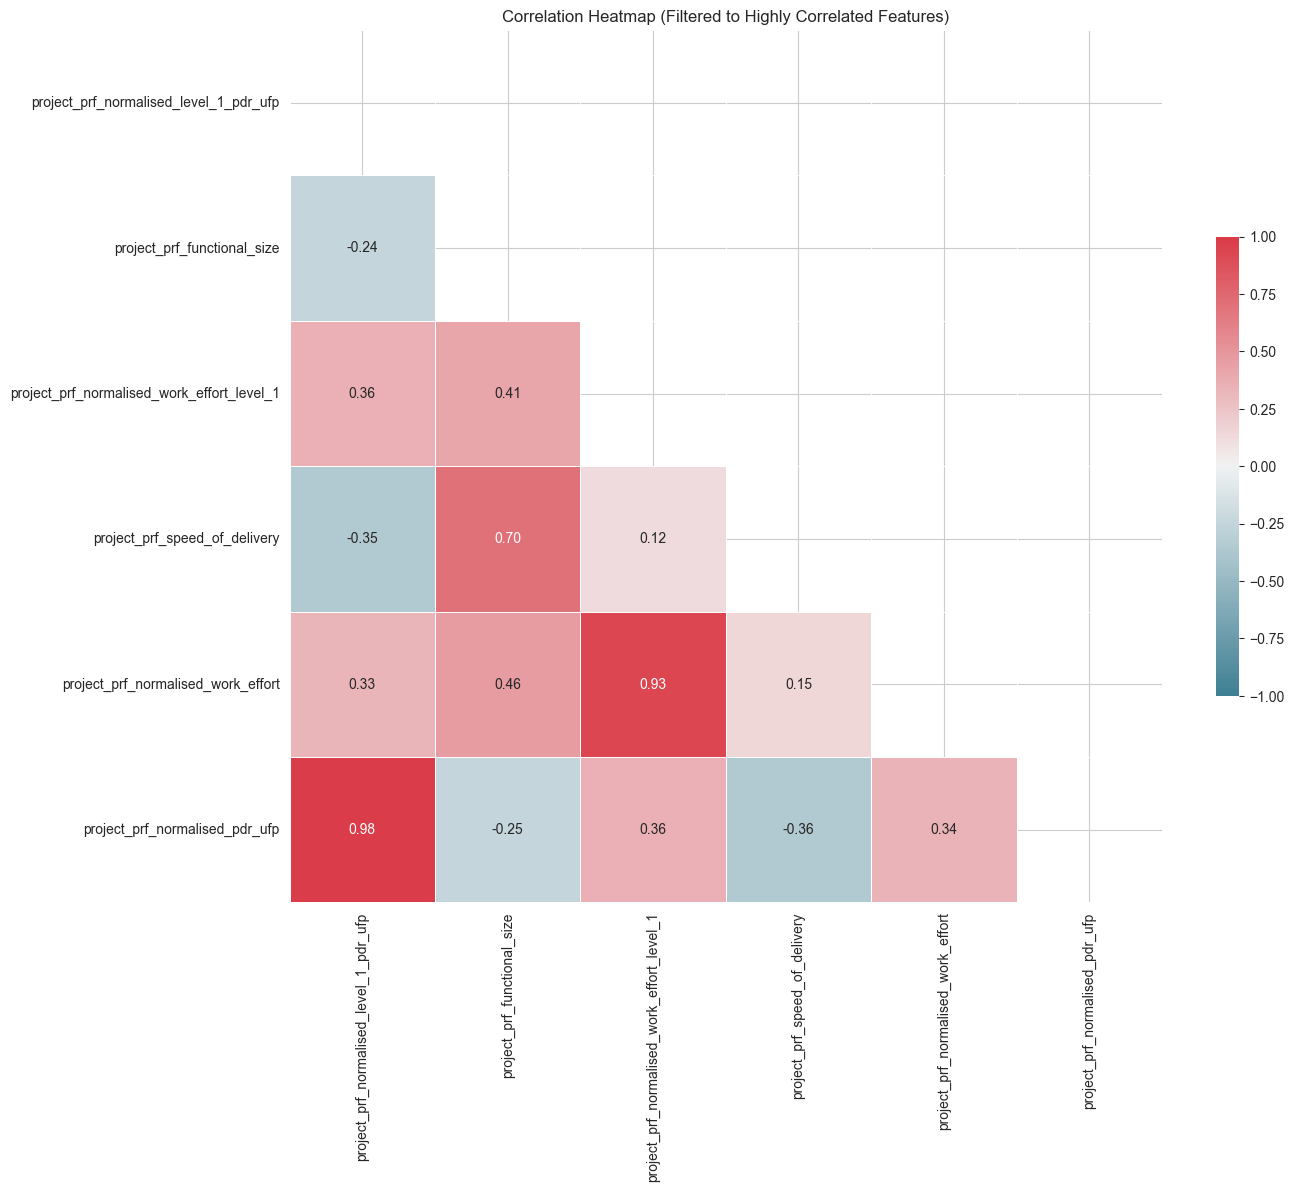

Correlation heatmap saved as ../plots/synthetic_ISBSG2016R1_1_agile_SDV_generated_correlation_heatmap.png
Number of samples (rows): 10000
Number of features (columns): 74
Minimum number of rows needed to calculate VIF: 75


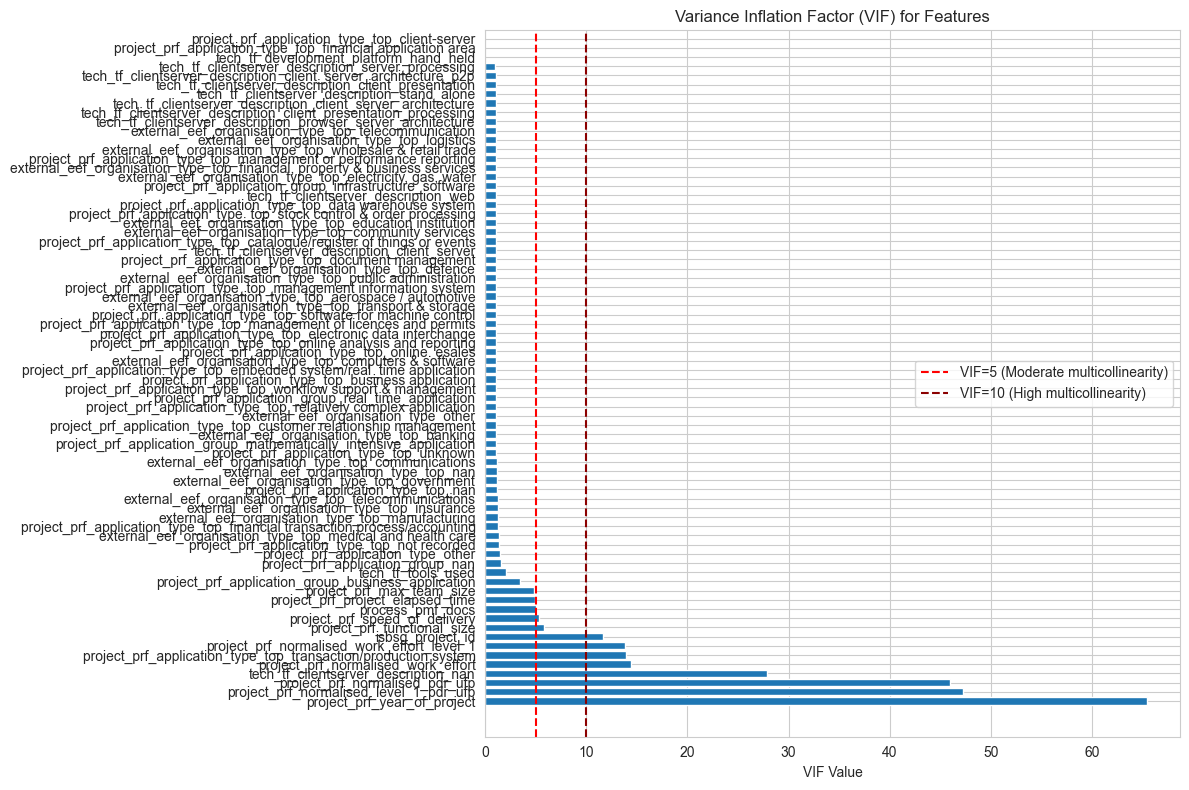

VIF values plot saved as ../plots/synthetic_ISBSG2016R1_1_agile_SDV_generated_vif_values.png

Found 3 feature pairs with correlation > 0.7:
  • project_prf_normalised_level_1_pdr_ufp and project_prf_normalised_pdr_ufp: 0.9807
  • project_prf_normalised_work_effort_level_1 and project_prf_normalised_work_effort: 0.9337
  • project_prf_functional_size and project_prf_speed_of_delivery: 0.7006

Features with high VIF (> 10):
  • project_prf_year_of_project: 65.46
  • project_prf_normalised_level_1_pdr_ufp: 47.27
  • project_prf_normalised_pdr_ufp: 45.99
  • tech_tf_clientserver_description_nan: 27.86
  • project_prf_normalised_work_effort: 14.43
  • project_prf_application_type_top_transaction/production system: 13.94
  • project_prf_normalised_work_effort_level_1: 13.86
  • isbsg_project_id: 11.68

--- Multicollinearity Analysis Recommendations ---
Consider addressing multicollinearity by:
1. Removing one feature from each highly correlated pair
2. Creating new features by combining corr

In [37]:
print("\nAnalyzing feature correlations...")

try:
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import os

    # Use your input DataFrame (before PyCaret setup)
    df_fixed = df

    # Optionally drop columns you know you want to ignore here, e.g.
    # df_fixed = df_fixed.drop(columns=ignore_cols, errors='ignore')

    # Create directory for plots
    os.makedirs(plots_folder, exist_ok=True)

    # Only numeric columns for analysis
    X_numeric = df_fixed.select_dtypes(include=[np.number])

    # --- Drop columns that are all NaN ---
    X_numeric = X_numeric.dropna(axis=1, how='all')

    # --- Replace inf/-inf with NaN and impute missing values with mean ---
    X_numeric_clean = X_numeric.replace([np.inf, -np.inf], np.nan)
    X_numeric_clean = X_numeric_clean.fillna(X_numeric_clean.mean())

    # Diagnostic prints
    print(f"Rows after dropping all-NaN columns: {X_numeric_clean.shape[0]}")
    print(f"Columns after dropping all-NaN columns: {X_numeric_clean.shape[1]}")
    print("Any column with all NaNs?", X_numeric_clean.isnull().all().any())
    print("Missing value count per column after cleaning:")
    print(X_numeric_clean.isnull().sum())

    # Number of features
    n_features = X_numeric_clean.shape[1]
    print(f"Analysing correlations among {n_features} numeric features")

    # Calculate correlation matrix
    corr_matrix = X_numeric_clean.corr()

    # Find highly correlated feature pairs
    correlation_threshold = 0.7
    high_corr_pairs = []
    for i in range(n_features):
        for j in range(i+1, n_features):
            if abs(corr_matrix.iloc[i, j]) > correlation_threshold:
                high_corr_pairs.append((
                    X_numeric_clean.columns[i],
                    X_numeric_clean.columns[j],
                    corr_matrix.iloc[i, j]
                ))

    # Plot correlation heatmap
    plt.figure(figsize=(14, 12))
    mask = np.triu(corr_matrix)
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    if n_features > 20:
        print(f"Large number of features detected ({n_features}). Creating filtered correlation matrix.")
        high_corr_features = set()
        for feat1, feat2, _ in high_corr_pairs:
            high_corr_features.add(feat1)
            high_corr_features.add(feat2)
        if high_corr_features:
            high_corr_features = list(high_corr_features)
            filtered_corr = corr_matrix.loc[high_corr_features, high_corr_features]
            sns.heatmap(filtered_corr, mask=np.triu(filtered_corr),
                        cmap=cmap, vmax=1, vmin=-1, center=0,
                        square=True, linewidths=.5, cbar_kws={"shrink": .5},
                        annot=True, fmt=".2f")
            plt.title('Correlation Heatmap (Filtered to Highly Correlated Features)')
        else:
            sns.heatmap(corr_matrix, mask=mask,
                        cmap=cmap, vmax=1, vmin=-1, center=0,
                        square=True, linewidths=.5, cbar_kws={"shrink": .5})
            plt.title('Correlation Heatmap (All Features)')
    else:
        sns.heatmap(corr_matrix, mask=mask,
                    cmap=cmap, vmax=1, vmin=-1, center=0,
                    square=True, linewidths=.5, cbar_kws={"shrink": .5},
                    annot=True, fmt=".2f")
        plt.title('Correlation Heatmap (All Features)')

    plt.tight_layout()
    plt.savefig(f"{plots_folder}/{file_name_no_ext}_correlation_heatmap.png")
    plt.show()
    plt.close()
    print(f"Correlation heatmap saved as {plots_folder}/{file_name_no_ext}_correlation_heatmap.png")

    # --- VIF calculation ---
    n_rows = X_numeric_clean.shape[0]
    n_features = X_numeric_clean.shape[1]
    min_rows_needed = n_features + 1
    print(f"Number of samples (rows): {n_rows}")
    print(f"Number of features (columns): {n_features}")
    print(f"Minimum number of rows needed to calculate VIF: {min_rows_needed}")

    vif_data = None
    if n_rows > n_features:
        try:
            from statsmodels.stats.outliers_influence import variance_inflation_factor

            vif_data = pd.DataFrame()
            vif_data["Feature"] = X_numeric_clean.columns
            vif_data["VIF"] = [variance_inflation_factor(X_numeric_clean.values, i)
                               for i in range(X_numeric_clean.shape[1])]

            vif_data = vif_data.sort_values("VIF", ascending=False)

            plt.figure(figsize=(12, 8))
            plt.barh(vif_data["Feature"], vif_data["VIF"])
            plt.axvline(x=5, color='r', linestyle='--', label='VIF=5 (Moderate multicollinearity)')
            plt.axvline(x=10, color='darkred', linestyle='--', label='VIF=10 (High multicollinearity)')
            plt.xlabel('VIF Value')
            plt.title('Variance Inflation Factor (VIF) for Features')
            plt.legend()
            plt.tight_layout()
            plt.savefig(f"{plots_folder}/{file_name_no_ext}_vif_values.png")
            plt.show()
            plt.close()
            print(f"VIF values plot saved as {plots_folder}/{file_name_no_ext}_vif_values.png")
        except Exception as vif_err:
            print(f"Could not calculate VIF: {vif_err}")
    else:
        print("Not enough samples to calculate VIF (need more samples than features)")

    # Print results
    print(f"\nFound {len(high_corr_pairs)} feature pairs with correlation > {correlation_threshold}:")
    for feat1, feat2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
        print(f"  • {feat1} and {feat2}: {corr:.4f}")

    if vif_data is not None:
        high_vif_threshold = 10
        high_vif_features = vif_data[vif_data["VIF"] > high_vif_threshold]
        if not high_vif_features.empty:
            print(f"\nFeatures with high VIF (> {high_vif_threshold}):")
            for _, row in high_vif_features.iterrows():
                print(f"  • {row['Feature']}: {row['VIF']:.2f}")
        else:
            print(f"\nNo features have VIF > {high_vif_threshold}")

    print("\n--- Multicollinearity Analysis Recommendations ---")
    if high_corr_pairs:
        print("Consider addressing multicollinearity by:")
        print("1. Removing one feature from each highly correlated pair")
        print("2. Creating new features by combining correlated features")
        print("3. Applying dimensionality reduction techniques like PCA")
        if len(high_corr_pairs) > 0:
            print("\nPotential candidates for removal:")
            freq = {}
            for feat1, feat2, _ in high_corr_pairs:
                freq[feat1] = freq.get(feat1, 0) + 1
                freq[feat2] = freq.get(feat2, 0) + 1
            freq_df = pd.DataFrame({'Feature': list(freq.keys()),
                                    'Frequency in high corr pairs': list(freq.values())})
            freq_df = freq_df.sort_values('Frequency in high corr pairs', ascending=False)
            for _, row in freq_df.head(5).iterrows():
                print(f"  • {row['Feature']} (appears in {row['Frequency in high corr pairs']} high correlation pairs)")
    else:
        print("No significant multicollinearity detected based on correlation analysis.")

    if vif_data is not None and not high_vif_features.empty:
        print("\nBased on VIF analysis, consider removing or transforming these features with high VIF values.")

except Exception as e:
    print(f"Feature correlation analysis failed: {e}")



In [38]:
# Save this DataFrame with fixed column names

df_fixed.to_csv(f'{data_folder}/{file_name_no_ext}_fixed_columns_data.csv', index=False)
print(f"Saved data with fixed column names to '{data_folder}/{file_name_no_ext}_fixed_columns_data.csv'")

Saved data with fixed column names to '../data/synthetic_ISBSG2016R1_1_agile_SDV_generated_fixed_columns_data.csv'
Cell executed at: 2025-06-03 14:34:26.944300


[Back to top](#Index:)

<a id='part4'></a>

# Part 4 - Data Profiling

xxx

In [39]:
# ## Data Profiling (Optional)

try:
    from ydata_profiling import ProfileReport
    
    print("\nGenerating data profile report...")
    profile = ProfileReport(df_clean, title="ISBSG-SDV Dataset Profiling Report", minimal=True)
    profile.to_file(f"{data_folder}/{file_name_no_ext}_data_profile_sdv.html")
    print(f"Data profile report saved to '{data_folder}/{file_name_no_ext}_data_profile_sdv.html'")
except ImportError:
    print("\nSkipping data profiling (ydata_profiling not installed)")
    print("To install: pip install ydata-profiling")


Generating data profile report...


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


%|          | 0/158 [00:00<?, ?it/s]
%|▋         | 10/158 [00:00<00:01, 93.17it/s]
%|█▎        | 20/158 [00:00<00:02, 64.54it/s]
%|████▊     | 77/158 [00:00<00:00, 233.04it/s]
%|██████▋   | 106/158 [00:00<00:00, 224.04it/s]
%|████████▎ | 131/158 [00:00<00:00, 206.17it/s]
100%|██████████| 158/158 [00:00<00:00, 186.15it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Data profile report saved to '../data/synthetic_ISBSG2016R1_1_agile_SDV_generated_data_profile_sdv.html'
Cell executed at: 2025-06-03 14:35:51.379654


[Back to top](#Index:)

<a id='part5'></a>

# Part 5 - PyCaret setup

xxx

In [40]:
print(sklearn.__version__)
print(pycaret.__version__)  

1.4.2
3.3.2
Cell executed at: 2025-06-03 14:36:17.972070


In [41]:
from pycaret.regression import setup, get_config
from sklearn.preprocessing import StandardScaler
import os

ignore_cols = ['isbsg_project_id', 'external_eef_data_quality_rating', 'external_eef_data_quality_rating_b', 'project_prf_normalised_work_effort_level_1', 'project_prf_normalised_level_1_pdr_ufp', 'project_prf_normalised_pdr_ufp', 
               'project_prf_project_elapsed_time', 'people_prf_ba_team_experience_less_than_1_yr', 'people_prf_ba_team_experience_1_to_3_yr', 
               'people_prf_ba_team_experience_great_than_3_yr', 'people_prf_it_experience_less_than_1_yr', 'people_prf_it_experience_1_to_3_yr', 
               'people_prf_it_experience_great_than_3_yr', 'people_prf_it_experience_less_than_3_yr', 'people_prf_it_experience_3_to_9_yr', 
               'people_prf_it_experience_great_than_9_yr', 'people_prf_project_manage_experience', 'project_prf_total_project_cost', 
               'project_prf_cost_currency', 'project_prf_currency_multiple', 'project_prf_speed_of_delivery', 'people_prf_project_manage_changes', 
               'project_prf_defect_density','project_prf_manpower_delivery_rate'
            ]

# Make all column names lowercase and underscores
df_fixed.columns = [col.lower() for col in df_fixed.columns]
ignore_cols = [col.lower() for col in ignore_cols]

#print(f"Final encoded feature list: {encoded_columns_fixed}")
# print(f"\nIgnred feature columns: {ignore_cols}")
setup_results = setup(
    data=df_fixed,
    target=TARGET_COL,
    ignore_features=ignore_cols,
    session_id=123,
    preprocess=True,
    # Add these lines to enable normalization (scaling)
    normalize=True,             # This will use StandardScaler (Z-score normalization) by default
    normalize_method='zscore',  # Explicitly state 'zscore', or choose 'minmax', 'maxabs', 'robust'
    verbose=False
)

# Get the fitted pipeline from PyCaret
preprocessor = get_config('pipeline')

# --- Capture the scaler model ---
# Access the 'normalize' step from the pipeline's named_steps
# The actual scaler object is inside the 'transformer' attribute of the TransformerWrapper
scaler_model = preprocessor.named_steps['normalize'].transformer

# Create the models folder if it doesn't exist
if not os.path.exists(models_folder):
    os.makedirs(models_folder)
    print(f"Created folder: {models_folder}")

# Define the file path for the scaler model
scaler_filename = os.path.join(models_folder, 'standard_scaler.pkl') # .pkl is a common extension for pickled files

# Create the models folder if it doesn't exist
if not os.path.exists(models_folder):
    os.makedirs(models_folder)
    print(f"Created folder: {models_folder}")

# Save the scaler model
joblib.dump(scaler_model, scaler_filename)
print(f"Scaler model saved to: {scaler_filename}")

# You can now print it to verify
print(scaler_model)

# You can also check its type
print(type(scaler_model))

# If it's a StandardScaler, it will have .mean_ and .scale_ attributes after fitting
if isinstance(scaler_model, StandardScaler):
    print(f"Scaler Mean: {scaler_model.mean_}")
    print(f"Scaler Scale (Std Dev): {scaler_model.scale_}")

# --- Example of using the captured scaler (on new data, assuming it's in the same format) ---
# Note: You typically use the entire PyCaret pipeline for new data,
# but if you specifically needed just the scaler for some custom preprocessing,
# you could do it like this:
#
# # Assuming 'new_numerical_data' is a pandas DataFrame or numpy array
# # containing only the numerical features that were scaled by PyCaret
# # (i.e., 'project_prf_year_of_project', 'project_prf_functional_size', etc.)
# scaled_data_custom = scaler_model.transform(new_numerical_data)
# print(scaled_data_custom)




Scaler model saved to: ../models\standard_scaler.pkl
StandardScaler()
<class 'sklearn.preprocessing._data.StandardScaler'>
Scaler Mean: [2.01072557e+03 1.11142857e-01 2.71428571e-02 2.65714286e-02
 1.28285714e-01 3.21428571e-02 2.81857143e-01 1.50857143e-01
 5.25714286e-02 7.28571429e-03 2.37142857e-02 3.11428571e-02
 1.92857143e-02 2.48571429e-02 4.60000000e-02 6.85714286e-03
 3.02857143e-02 4.15332027e+03 2.28526286e+02 3.90000000e-01
 1.91428571e-02 8.17142857e-02 2.05714286e-02 1.44285714e-02
 2.68000000e-01 2.51428571e-02 1.65714286e-02 4.18571429e-02
 1.78571429e-02 3.48571429e-02 4.18571429e-02 8.42857143e-03
 3.85714286e-03 1.57142857e-02 1.52860211e+01 1.00000000e+00
 4.50328571e+00 1.00000000e+00 4.12845144e+03 1.47442857e+00
 6.54571429e-01 8.85714286e-03 6.08571429e-02 2.48857143e-01
 4.85714286e-02 9.32944606e-03 1.62554427e-02 2.91587695e-04
 1.90030697e-03 2.33100233e-03 1.45857643e-04 9.64244186e-01
 4.35729847e-04 1.75233645e-03 6.13049190e-03 1.21857143e-01
 3.0285714

[Back to top](#Index:)

<a id='part6'></a>

# Part 6 - Model Building with PyCaret

xxx

In [42]:
from pycaret.regression import *
from sklearn.base import BaseEstimator
import joblib
import time

# Start timing
start_time = time.time()

# Create output directories if needed
os.makedirs(data_folder, exist_ok=True)
os.makedirs(models_folder, exist_ok=True)
os.makedirs(skeleton_models_folder, exist_ok=True)
os.makedirs(logs_folder, exist_ok=True)


# Get preprocessed data for inspection and saving
X = get_config("X")
y = get_config("y")

# Print all feature names ---
print("All preprocessed feature names (as list):", X.columns.tolist())


X.to_csv(f"{data_folder}/pycaret_processed_features_before_model_training.csv", index=False)
y.to_csv(f"{data_folder}/pycaret_processed_target_before_model_training.csv", index=False)
print(f"\nPreprocessed data shape: {X.shape}")
print(f"Numeric features: {len(X.select_dtypes(include=[float, int]).columns)}")
print(f"Categorical features: {len(X.select_dtypes(include=['object', 'category']).columns)}")
print("Preprocessed features and target saved.")


# 1. Compare and select top 3 models (returns list of models)
print("\nComparing regression models and selecting top 3...")
top_models = compare_models(n_select=3)
model_results = pull()
model_results.to_csv(f"{logs_folder}/model_comparison_results.csv")
print("\nModel comparison results:")
print(model_results)

# 2. For each top model: tune, evaluate, and save
tuned_models = []
scores = []

for i, model in enumerate(top_models, 1):
    model_name = type(model).__name__
    print(f"\nModel {i}: {model_name}")
    
    # Tune
    print("  Tuning...")
    tuned = tune_model(model, n_iter=10)
    tuned_models.append(tuned)

    # Pull results after tuning - get the mean values
    tuned_results = pull()
    tuned_results.to_csv(f'{logs_folder}/tuned_results_model_{i}_{model_name}.csv')
    
    # Extract metrics from "Mean" column instead of "Value"
    try:
        # First try to access by 'Mean' column which is the typical format
        scores.append({
            'Model': model_name, 
            'MAE': tuned_results.loc['MAE', 'Mean'],
            'RMSE': tuned_results.loc['RMSE', 'Mean'],
            'R2': tuned_results.loc['R2', 'Mean']
        })
    except KeyError:
        # As a fallback, check the structure of tuned_results
        print(f"  Warning: Expected column structure not found in tuned results")
        print(f"  tuned_results columns: {tuned_results.columns}")
        print(f"  tuned_results index: {tuned_results.index}")
        
        # Try alternative approaches based on the actual structure
        if 'Mean' in tuned_results.columns:
            scores.append({
                'Model': model_name,
                'MAE': tuned_results.loc['MAE', 'Mean'] if 'MAE' in tuned_results.index else None,
                'RMSE': tuned_results.loc['RMSE', 'Mean'] if 'RMSE' in tuned_results.index else None,
                'R2': tuned_results.loc['R2', 'Mean'] if 'R2' in tuned_results.index else None
            })
        elif len(tuned_results.columns) > 0:
            # Get the last column as it might contain mean values
            last_col = tuned_results.columns[-1]
            scores.append({
                'Model': model_name,
                'MAE': tuned_results.loc['MAE', last_col] if 'MAE' in tuned_results.index else None,
                'RMSE': tuned_results.loc['RMSE', last_col] if 'RMSE' in tuned_results.index else None,
                'R2': tuned_results.loc['R2', last_col] if 'R2' in tuned_results.index else None
            })
        else:
            # If we still can't find the right structure, log the issue
            scores.append({
                'Model': model_name,
                'MAE': None,
                'RMSE': None,
                'R2': None
            })
            print(f"  Unable to extract metrics for {model_name}. Check the saved CSV for details.")
    
    # Before saving, check what the model input features
    print("Before saving:")
    print(f"Model type: {type(tuned)}")

    # Try to get feature names before saving
    try:
        if hasattr(tuned, 'feature_names_in_'):
            print(f"Features before save: {tuned.feature_names_in_}")
            print(f"Number of features: {len(tuned.feature_names_in_)}")
    except:
        print("Could not get features before save")
    
    # Save tuned model
    save_model(tuned, f"{models_folder}/top_model_{i}_{model_name}")
    print(f"  Saved as {models_folder}/top_model_{i}_{model_name}.pkl")
    print(f"  Time elapsed: {time.time() - start_time:.1f} seconds")

    print("After saving:")
    verify_loaded_model = load_model(f"{models_folder}/top_model_{i}_{model_name}")
    try:
        if hasattr(verify_loaded_model, 'feature_names_in_'):
            print(f"Features loaded from pkl file: { verify_loaded_model.feature_names_in_}")
            print(f"Number of features: {len(verify_loaded_model.feature_names_in_)}")
    except:
        print("Could not get features after save the model")

    # just save skeleton mode
    final_model = finalize_model(tuned)  # This removes PyCaret wrapper
    sklearn_model = final_model[-1]  # Extract just the sklearn model

    # ADD THIS: Preserve feature names before saving
    if hasattr(final_model, 'feature_names_in_'):
        sklearn_model.feature_names_in_ = final_model.feature_names_in_
        
    print(f"Number of features: {len(sklearn_model.feature_names_in_)}")
    joblib.dump(sklearn_model, f"{skeleton_models_folder}/top_model_skeleton_{i}_{model_name}.pkl")
    print(f"  Saved as {skeleton_models_folder}/top_model_skeleton_{i}_{model_name}.pkl")
    

    # When loading - you'll need to handle preprocessing separately
    sklearn_model_loaded = joblib.load(f"{skeleton_models_folder}/top_model_skeleton_{i}_{model_name}.pkl")
    print("\nAfter loading:")
    try:
        if hasattr(sklearn_model_loaded, 'feature_names_in_'):  # Fixed variable name
            print(f"Features after skeleton load: {sklearn_model_loaded.feature_names_in_}")  # Fixed variable name
            print(f"Number of features: {len(sklearn_model_loaded.feature_names_in_)}")
        else:
            print("No feature_names_in_ attribute found")
    except Exception as e:
        print(f"Could not get features after load: {e}")


# Save overall summary of all tuned models
score_df = pd.DataFrame(scores)
score_df.to_csv(f"{logs_folder}/tuned_model_scores.csv", index=False)
print("\nTuned models summary:\n", score_df)
print("\nAll top 3 models have been tuned, evaluated, and saved.")
print("\nAnalysis complete! Proceed with feature importance or SHAP analysis as next steps.")

# 3. Optionally: Pull the best model for additional analysis (feature importance, SHAP, etc.)
# You can access the best model as top_models[0] or reload any saved model later



All preprocessed feature names (as list): ['project_prf_year_of_project', 'external_eef_industry_sector', 'tech_tf_primary_programming_language', 'project_prf_functional_size', 'project_prf_team_size_group', 'project_prf_max_team_size', 'process_pmf_development_methodologies', 'process_pmf_docs', 'tech_tf_client_roles', 'tech_tf_server_roles', 'tech_tf_tools_used', 'project_prf_application_group_business_application', 'project_prf_application_group_infrastructure_software', 'project_prf_application_group_mathematically_intensive_application', 'project_prf_application_group_nan', 'project_prf_application_group_real_time_application', 'tech_tf_clientserver_description_browser_server_architecture', 'tech_tf_clientserver_description_client_server', 'tech_tf_clientserver_description_client_presentation', 'tech_tf_clientserver_description_client_presentation_processing', 'tech_tf_clientserver_description_client_server_architecture', 'tech_tf_clientserver_description_client_server_architectur

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2387.5270,15739739.6681,3758.3364,0.3971,1.3720,7.0246,0.8700
et,Extra Trees Regressor,2458.8801,16333613.5606,3827.8992,0.3786,1.4064,8.1262,5.5370
rf,Random Forest Regressor,2446.7214,16297450.3336,3825.4533,0.3784,1.3961,7.6963,4.1130
omp,Orthogonal Matching Pursuit,2538.2488,16384228.0899,3834.5139,0.3764,1.4813,10.5718,0.1710
br,Bayesian Ridge,2570.3377,16588692.5362,3858.6046,0.3702,1.5056,12.1503,0.2610
lasso,Lasso Regression,2581.0836,16599005.4581,3859.9666,0.3697,1.5098,12.3920,0.3300
llar,Lasso Least Angle Regression,2581.0799,16598987.9577,3859.9644,0.3697,1.5097,12.3918,0.1530
ridge,Ridge Regression,2583.3084,16611029.7009,3861.3748,0.3694,1.5114,12.4445,0.1450
lar,Least Angle Regression,2583.3789,16611212.2947,3861.3968,0.3693,1.5110,12.4461,0.1530
huber,Huber Regressor,2407.9143,17562683.9637,3968.7071,0.3398,1.4129,8.6625,0.2320



Model comparison results:
                              Model           MAE           MSE          RMSE  \
gbr     Gradient Boosting Regressor  2.387527e+03  1.573974e+07  3.758336e+03   
et            Extra Trees Regressor  2.458880e+03  1.633361e+07  3.827899e+03   
rf          Random Forest Regressor  2.446721e+03  1.629745e+07  3.825453e+03   
omp     Orthogonal Matching Pursuit  2.538249e+03  1.638423e+07  3.834514e+03   
br                   Bayesian Ridge  2.570338e+03  1.658869e+07  3.858605e+03   
lasso              Lasso Regression  2.581084e+03  1.659901e+07  3.859967e+03   
llar   Lasso Least Angle Regression  2.581080e+03  1.659899e+07  3.859964e+03   
ridge              Ridge Regression  2.583308e+03  1.661103e+07  3.861375e+03   
lar          Least Angle Regression  2.583379e+03  1.661121e+07  3.861397e+03   
huber               Huber Regressor  2.407914e+03  1.756268e+07  3.968707e+03   
en                      Elastic Net  2.607536e+03  1.759277e+07  3.972818e+03   
p

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3938.5113,37983107.0812,6163.0437,-0.0002,2.2501,46.1657
1,4044.8630,34386682.7752,5864.0159,-0.0052,2.1280,35.7727
2,3818.8078,29991330.7569,5476.4341,-0.0037,2.2255,37.5379
3,3960.1228,33466551.1163,5785.0282,-0.0010,2.1412,33.7451
4,3637.9746,27238739.2846,5219.0746,-0.0010,2.0665,28.8893
5,3911.8763,31102231.5620,5576.9375,-0.0027,2.0330,28.5428
6,3746.5051,26754775.8028,5172.5019,-0.0004,2.2237,48.9557
7,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000
8,3782.7333,28009593.7368,5292.4091,-0.0013,2.2082,47.0231


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
  tuned_results columns: Index(['MAE', 'MSE', 'RMSE', 'R2', 'RMSLE', 'MAPE'], dtype='object')
  tuned_results index: Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 'Mean', 'Std'], dtype='object', name='Fold')
Before saving:
Model type: <class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
Features before save: ['project_prf_year_of_project'
 'external_eef_industry_sector_medical & health care'
 'external_eef_industry_sector_professional services'
 'external_eef_industry_sector_electronics & computers'
 'external_eef_industry_sector_insurance'
 'external_eef_industry_sector_financial'
 'external_eef_industry_sector_government'
 'external_eef_industry_sector_manufacturing'
 'external_eef_industry_sector_banking'
 'external_eef_industry_sector_mining'
 'external_eef_industry_sector_utili

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3455.3620,30113234.3273,5487.5527,0.2071,2.0981,34.4811
1,3499.1420,27194768.2139,5214.8603,0.2050,1.9698,24.7265
2,3290.0513,23323747.9366,4829.4666,0.2194,2.0768,27.2831
3,3527.0991,27119456.8884,5207.6345,0.1889,2.0092,25.1573
4,3224.3947,22431262.1014,4736.1653,0.1757,1.9317,21.6646
5,3396.7516,24608835.3852,4960.7293,0.2067,1.8872,21.5074
6,3311.0784,21909802.1795,4680.7908,0.1808,2.0795,33.1255
7,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000
8,3334.4811,22352626.9922,4727.8565,0.2009,2.0694,35.2991


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
  tuned_results columns: Index(['MAE', 'MSE', 'RMSE', 'R2', 'RMSLE', 'MAPE'], dtype='object')
  tuned_results index: Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 'Mean', 'Std'], dtype='object', name='Fold')
Before saving:
Model type: <class 'sklearn.ensemble._forest.ExtraTreesRegressor'>
Features before save: ['project_prf_year_of_project'
 'external_eef_industry_sector_medical & health care'
 'external_eef_industry_sector_professional services'
 'external_eef_industry_sector_electronics & computers'
 'external_eef_industry_sector_insurance'
 'external_eef_industry_sector_financial'
 'external_eef_industry_sector_government'
 'external_eef_industry_sector_manufacturing'
 'external_eef_industry_sector_banking'
 'external_eef_industry_sector_mining'
 'external_eef_industry_sector_utiliti

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3255.1624,27272057.1260,5222.2655,0.2819,2.0193,29.6138
1,3202.0363,23629338.9932,4861.0019,0.3092,1.8818,20.4210
2,2990.1771,19959099.2437,4467.5608,0.3321,1.9800,22.4382
3,3246.6005,23613073.6348,4859.3285,0.2937,1.9183,20.4765
4,2986.2631,19555088.1036,4422.1135,0.2814,1.8504,18.0385
5,3167.0166,21909391.2450,4680.7469,0.2937,1.8139,18.1120
6,3044.4762,19620944.8910,4429.5536,0.2664,1.9933,27.3437
7,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000
8,3060.3067,19177351.9080,4379.1953,0.3144,1.9798,28.7773


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
  tuned_results columns: Index(['MAE', 'MSE', 'RMSE', 'R2', 'RMSLE', 'MAPE'], dtype='object')
  tuned_results index: Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 'Mean', 'Std'], dtype='object', name='Fold')
Before saving:
Model type: <class 'sklearn.ensemble._forest.RandomForestRegressor'>
Features before save: ['project_prf_year_of_project'
 'external_eef_industry_sector_medical & health care'
 'external_eef_industry_sector_professional services'
 'external_eef_industry_sector_electronics & computers'
 'external_eef_industry_sector_insurance'
 'external_eef_industry_sector_financial'
 'external_eef_industry_sector_government'
 'external_eef_industry_sector_manufacturing'
 'external_eef_industry_sector_banking'
 'external_eef_industry_sector_mining'
 'external_eef_industry_sector_utili

[Back to top](#Index:)

<a id='part8'></a>

# Part 8 - Feature Importance

xxx

In [43]:
# Only some models (e.g., tree-based models like Random Forest, XGBoost, LightGBM) have feature_importances_.
# Many linear models (like LinearRegression, Lasso), KNN, and some ensemble models do not.

# print(type(tuned_model))

for i, m in enumerate(tuned_models, 1):
    print(f"Model {i} type: {type(m)}")



Model 1 type: <class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
Model 2 type: <class 'sklearn.ensemble._forest.ExtraTreesRegressor'>
Model 3 type: <class 'sklearn.ensemble._forest.RandomForestRegressor'>
Cell executed at: 2025-06-03 14:55:34.844436


In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import pandas as pd

def plot_linear_feature_importance(model, X, y, feature_names=None, method='coefficients'):
    """
    Plot feature importance for Linear models
    
    Parameters:
    -----------
    model : trained linear model
    X : feature matrix
    y : target vector
    feature_names : list of feature names (optional)
    method : 'coefficients' or 'permutation'
    """
    
    # Create directory for plots if it doesn't exist
    import os
    os.makedirs(plots_folder, exist_ok=True)
    
    # Get feature names if not provided
    if feature_names is None:
        if hasattr(X, 'columns'):  # If X is a DataFrame
            feature_names = X.columns.tolist()
        else:
            feature_names = [f'Feature {i}' for i in range(X.shape[1])]
    
    plt.figure(figsize=(10, 6))
    
    if method == 'coefficients':
        # Use absolute coefficient values as feature importance
        importances = np.abs(model.coef_)
        indices = np.argsort(importances)
        
        plt.title('Feature Importance Based on Coefficient Magnitude')
        plt.barh(range(len(indices)), importances[indices], align='center')
        plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
        plt.xlabel('Absolute Coefficient Magnitude')
        
    elif method == 'permutation':
        # Calculate permutation importance
        result = permutation_importance(
            model, X, y, n_repeats=10, random_state=42, n_jobs=-1
        )
        
        importances = result.importances_mean
        std = result.importances_std
        indices = np.argsort(importances)
        
        plt.title('Feature Importance Based on Permutation Importance')
        plt.barh(range(len(indices)), importances[indices], xerr=std[indices], align='center')
        plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
        plt.xlabel('Permutation Importance')
    
    plt.tight_layout()
    plt.savefig(f'{plots_folder}/{plots_folder}/{file_name_no_ext}_linear_feature_importance_{method}.png')
    print(f'Feature importance plot saved to {plots_folder}/{plots_folder}/{file_name_no_ext}_linear_feature_importance_{method}.png')
    
    # Return the importances for potential further analysis
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    return importance_df

# Example usage:
# plot_linear_feature_importance(linear_model, X, y, feature_names=X.columns, method='coefficients')
# plot_linear_feature_importance(linear_model, X, y, feature_names=X.columns, method='permutation')

Cell executed at: 2025-06-03 14:55:34.881201


All features: ['project_prf_year_of_project', 'external_eef_industry_sector', 'tech_tf_primary_programming_language', 'project_prf_functional_size', 'project_prf_team_size_group', 'project_prf_max_team_size', 'process_pmf_development_methodologies', 'process_pmf_docs', 'tech_tf_client_roles', 'tech_tf_server_roles', 'tech_tf_tools_used', 'project_prf_application_group_business_application', 'project_prf_application_group_infrastructure_software', 'project_prf_application_group_mathematically_intensive_application', 'project_prf_application_group_nan', 'project_prf_application_group_real_time_application', 'tech_tf_clientserver_description_browser_server_architecture', 'tech_tf_clientserver_description_client_server', 'tech_tf_clientserver_description_client_presentation', 'tech_tf_clientserver_description_client_presentation_processing', 'tech_tf_clientserver_description_client_server_architecture', 'tech_tf_clientserver_description_client_server_architecture_p2p', 'tech_tf_clientserve

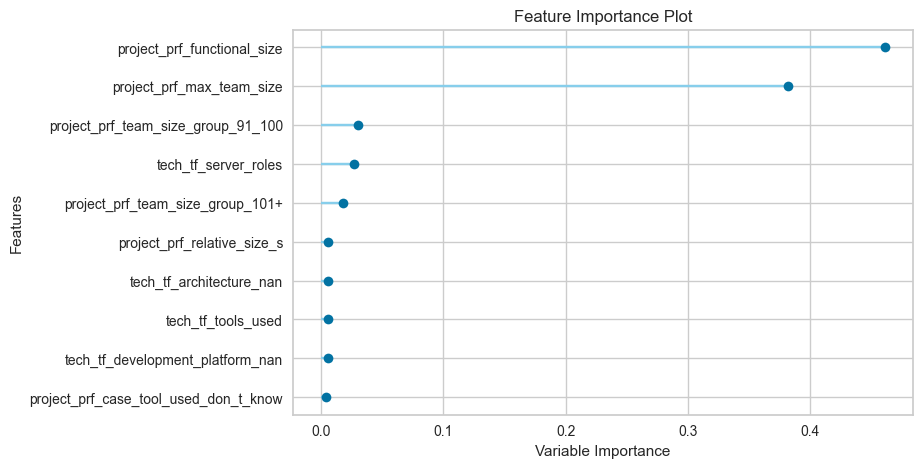

<Figure size 800x550 with 0 Axes>

  PyCaret feature importance plot saved to ../plots/synthetic_ISBSG2016R1_1_agile_SDV_generated_feature_importance_model_1_GradientBoostingRegressor.png

Model 2: ExtraTreesRegressor


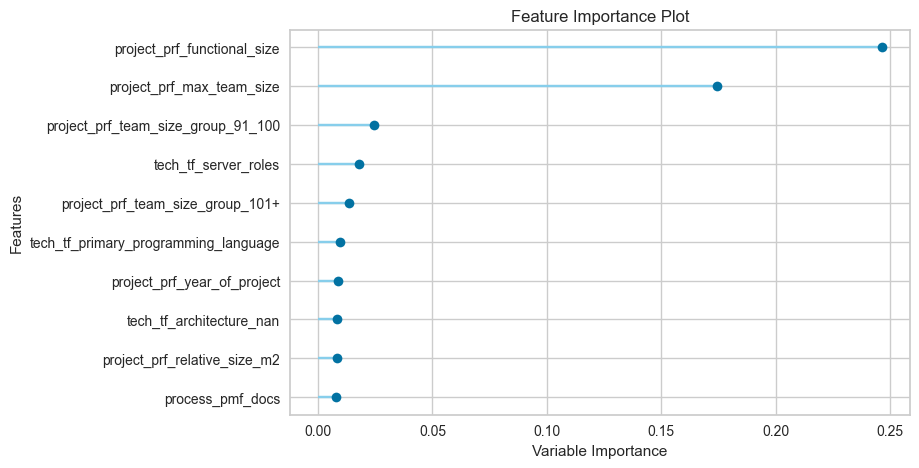

<Figure size 800x550 with 0 Axes>

  PyCaret feature importance plot saved to ../plots/synthetic_ISBSG2016R1_1_agile_SDV_generated_feature_importance_model_2_ExtraTreesRegressor.png

Model 3: RandomForestRegressor


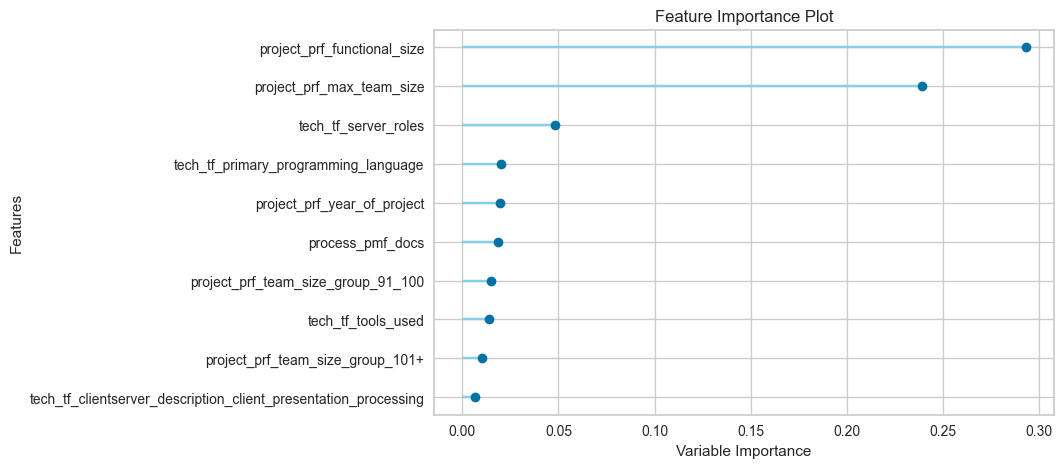

<Figure size 800x550 with 0 Axes>

  PyCaret feature importance plot saved to ../plots/synthetic_ISBSG2016R1_1_agile_SDV_generated_feature_importance_model_3_RandomForestRegressor.png
Cell executed at: 2025-06-03 14:55:37.580705


In [45]:
# code modified for top 3 models

from pycaret.regression import plot_model
import os
import matplotlib.pyplot as plt

pycaret_X=X
pycaret_y = y

os.makedirs(plots_folder, exist_ok=True)
feature_names = pycaret_X.columns.tolist()  # Make sure to use the same data as in training
print(f"All features: {feature_names}")


for i, tuned_model in enumerate(tuned_models, 1):
    model_name = type(tuned_model).__name__
    print(f"\nModel {i}: {model_name}")

    # First try PyCaret's plot_model
    try:
        plot_model(tuned_model, plot='feature', save=False)
        plt.savefig(f'{plots_folder}/{file_name_no_ext}_feature_importance_model_{i}_{model_name}.png')
        plt.show()
        plt.close()
        print(f"  PyCaret feature importance plot saved to {plots_folder}/{file_name_no_ext}_feature_importance_model_{i}_{model_name}.png")
    except Exception as e:
        print(f"  PyCaret plot_model failed: {e}")
        # Fallback for linear models with coefficients
        try:
            # If it's a linear model (like HuberRegressor, LinearRegression, etc.)
            if hasattr(tuned_model, 'coef_'):
                importance_df = plot_linear_feature_importance(
                    tuned_model, pycaret_X, pycaret_y, 
                    feature_names=feature_names, 
                    method='coefficients'
                )
                print("  Custom coefficient-based feature importance plot saved.")
                print("  All important features:")
                print(importance_df)
            else:
                print("  This model does not support .coef_ or is not a linear model.")
        except Exception as e2:
            print(f"  Could not generate feature plot for linear model: {e2}")

    # Optionally: also plot permutation-based feature importance for all linear models
    if hasattr(tuned_model, 'coef_'):
        print("\n  Generating permutation-based feature importance plot...")
        try:
            importance_df_perm = plot_linear_feature_importance(
                tuned_model, pycaret_X, pycaret_y, 
                feature_names=feature_names, 
                method='permutation'
            )
            print("  Allimportant features (permutation):")
            print(importance_df_perm)
        except Exception as e:
            print(f"  Could not generate permutation feature plot: {e}")


[Back to top](#Index:)

<a id='part9'></a>

# Part 9 - SHAP Analysis

xxx


==================== MODEL 1 ====================
SHAP already installed
Plots will be saved to: C:\Users\jdche\Documents\GitHub\early_agile_estimator\plots
Starting SHAP Analysis...
Data shape: (10000, 182)
Using 100 samples for analysis
Model type: GradientBoostingRegressor
Using TreeExplainer

SHAP PLOTS
Summary plot saved to: ../plots/shap_summary_GradientBoostingRegressor.png


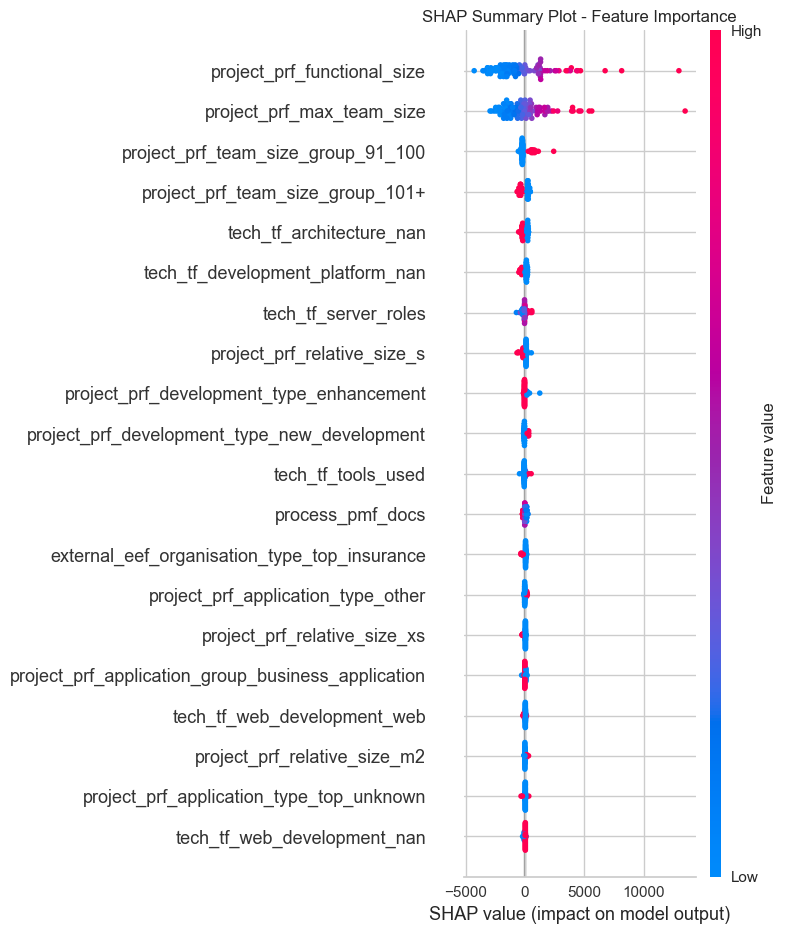

Summary plot created
Bar plot saved to: ../plots/synthetic_ISBSG2016R1_1_agile_SDV_generated_shap_importance_bar_GradientBoostingRegressor.png


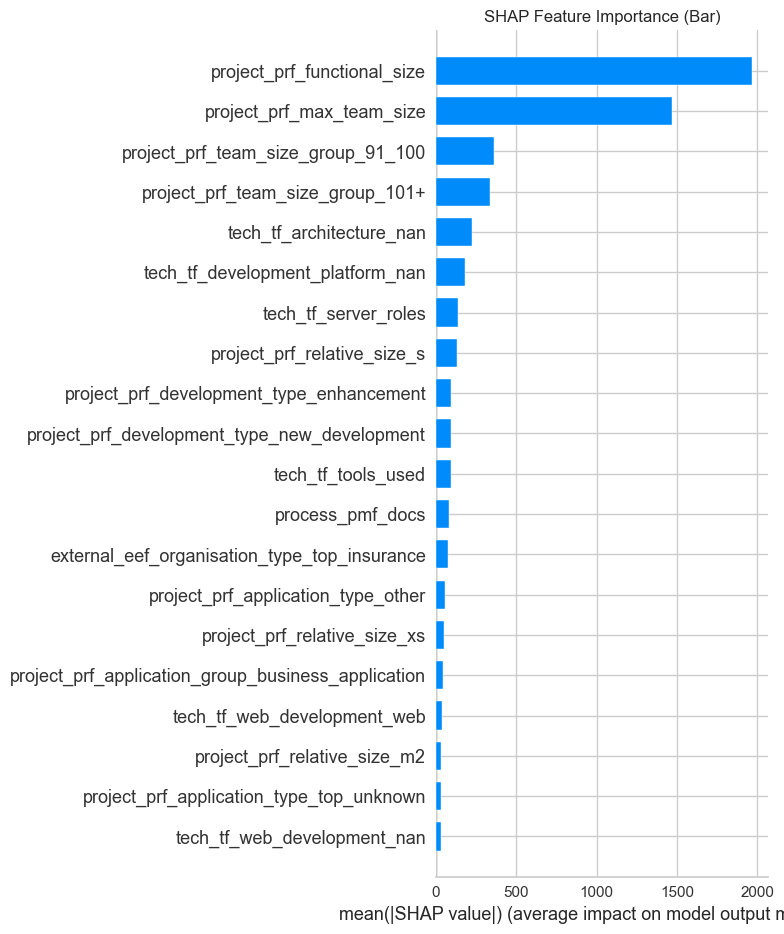

Bar plot created
Dependence plot saved to: ../plots/synthetic_ISBSG2016R1_1_agile_SDV_generated_shap_dependence_project_prf_functional_size_GradientBoostingRegressor.png


<Figure size 1000x600 with 0 Axes>

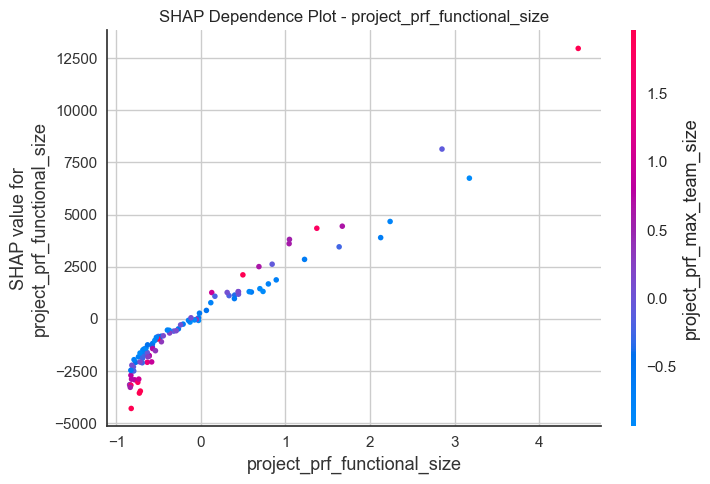

Dependence plot for 'project_prf_functional_size' created
Using modern waterfall plot...
Waterfall plot saved to: ../plots/synthetic_ISBSG2016R1_1_agile_SDV_generated_shap_waterfall_GradientBoostingRegressor.png


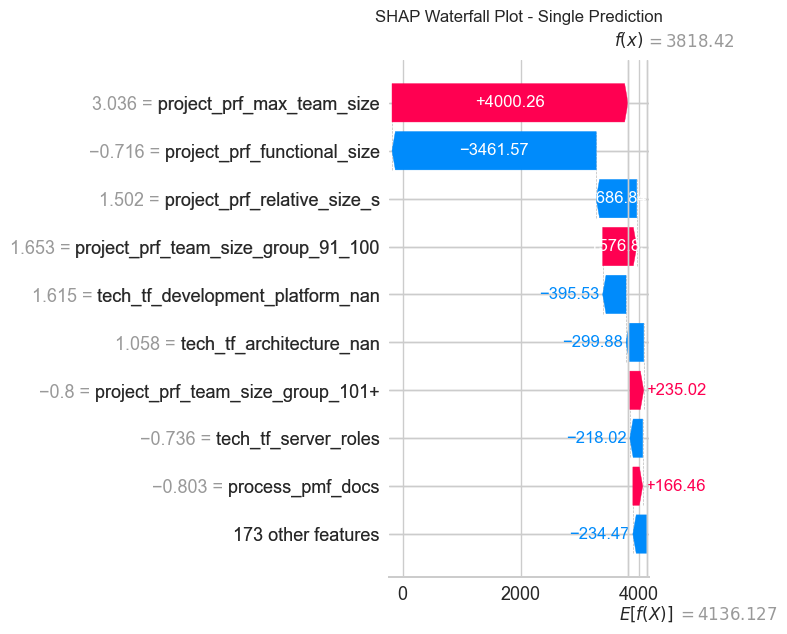

Waterfall plot created

All plots saved to folder: C:\Users\jdche\Documents\GitHub\early_agile_estimator\plots

SHAP Analysis Complete!

==================== MODEL 2 ====================
SHAP already installed
Plots will be saved to: C:\Users\jdche\Documents\GitHub\early_agile_estimator\plots
Starting SHAP Analysis...
Data shape: (10000, 182)
Using 100 samples for analysis
Model type: ExtraTreesRegressor
Using TreeExplainer

SHAP PLOTS
Summary plot saved to: ../plots/shap_summary_ExtraTreesRegressor.png


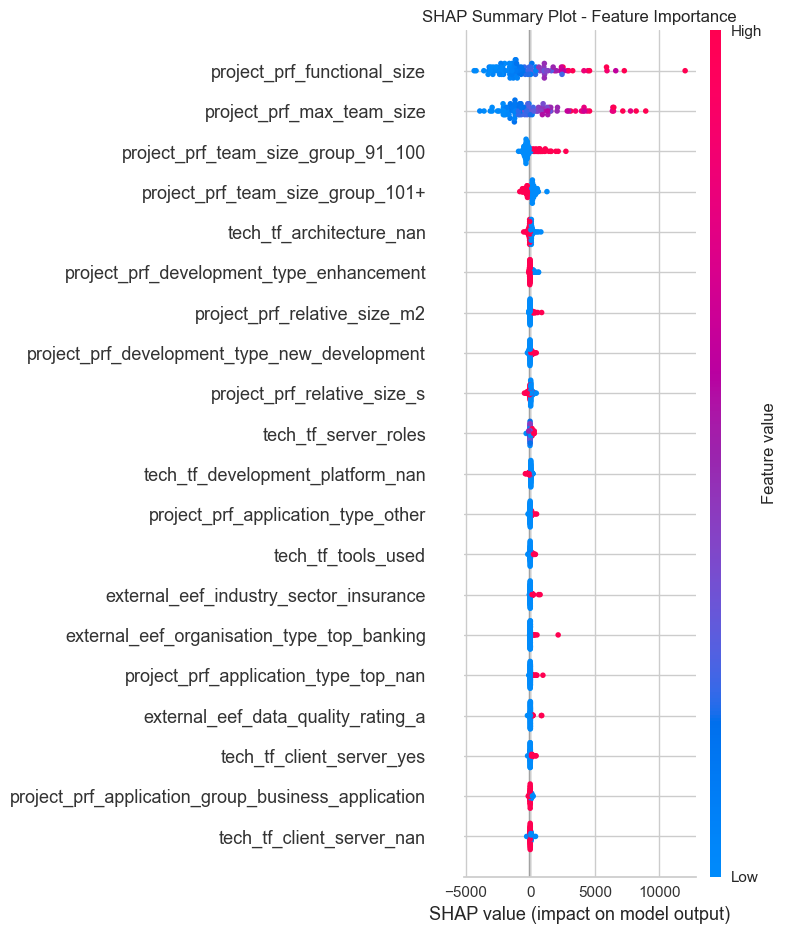

Summary plot created
Bar plot saved to: ../plots/synthetic_ISBSG2016R1_1_agile_SDV_generated_shap_importance_bar_ExtraTreesRegressor.png


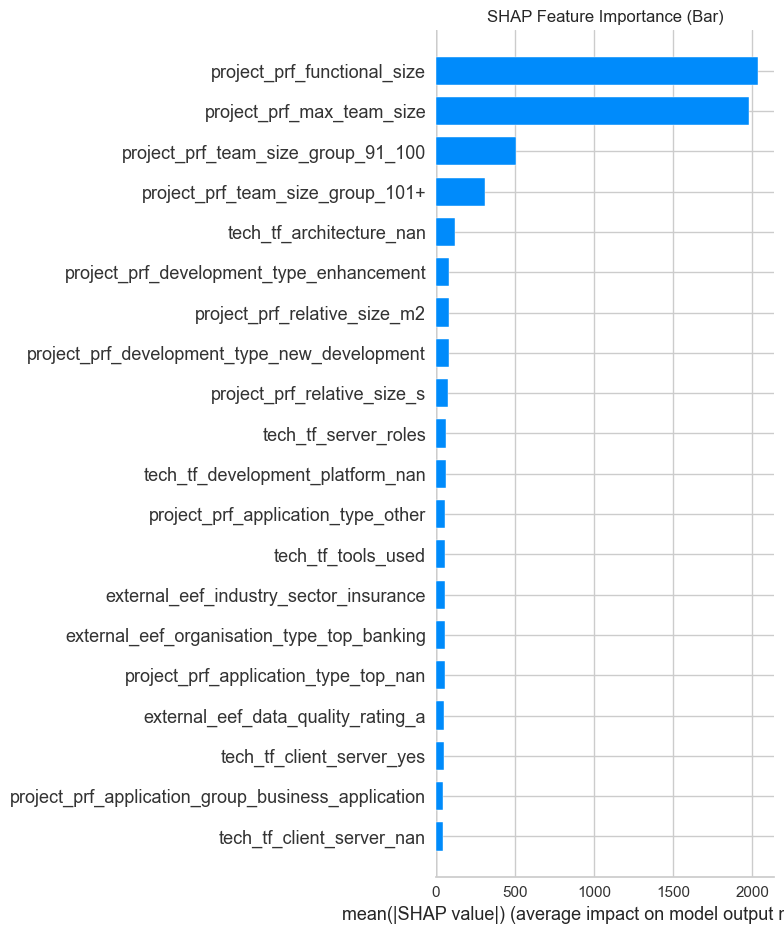

Bar plot created
Dependence plot saved to: ../plots/synthetic_ISBSG2016R1_1_agile_SDV_generated_shap_dependence_project_prf_functional_size_ExtraTreesRegressor.png


<Figure size 1000x600 with 0 Axes>

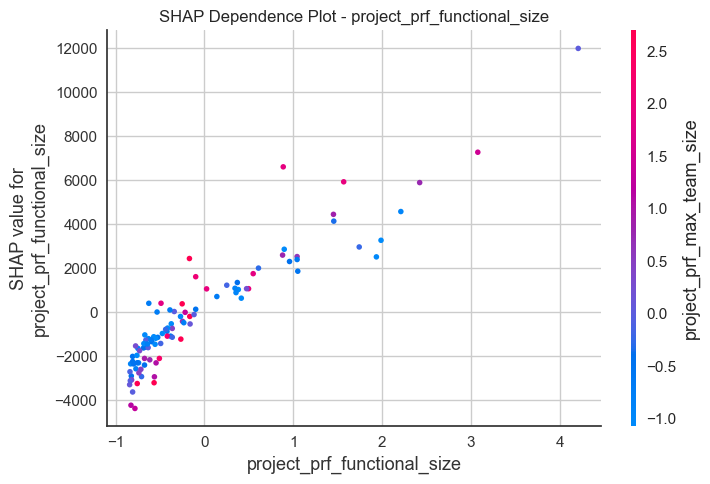

Dependence plot for 'project_prf_functional_size' created
Using modern waterfall plot...
Waterfall plot saved to: ../plots/synthetic_ISBSG2016R1_1_agile_SDV_generated_shap_waterfall_ExtraTreesRegressor.png


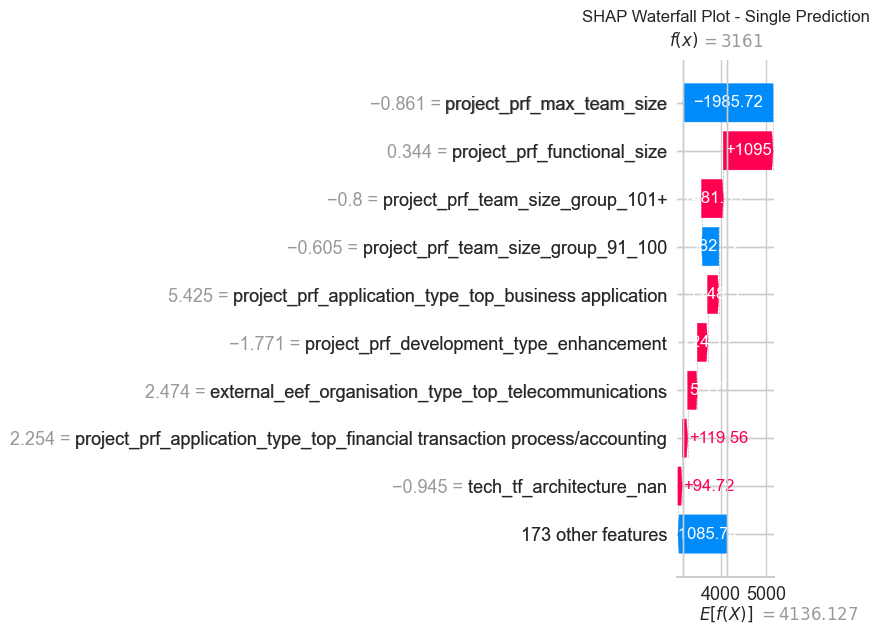

Waterfall plot created

All plots saved to folder: C:\Users\jdche\Documents\GitHub\early_agile_estimator\plots

SHAP Analysis Complete!

==================== MODEL 3 ====================
SHAP already installed
Plots will be saved to: C:\Users\jdche\Documents\GitHub\early_agile_estimator\plots
Starting SHAP Analysis...
Data shape: (10000, 182)
Using 100 samples for analysis
Model type: RandomForestRegressor
Using TreeExplainer

SHAP PLOTS
Summary plot saved to: ../plots/shap_summary_RandomForestRegressor.png


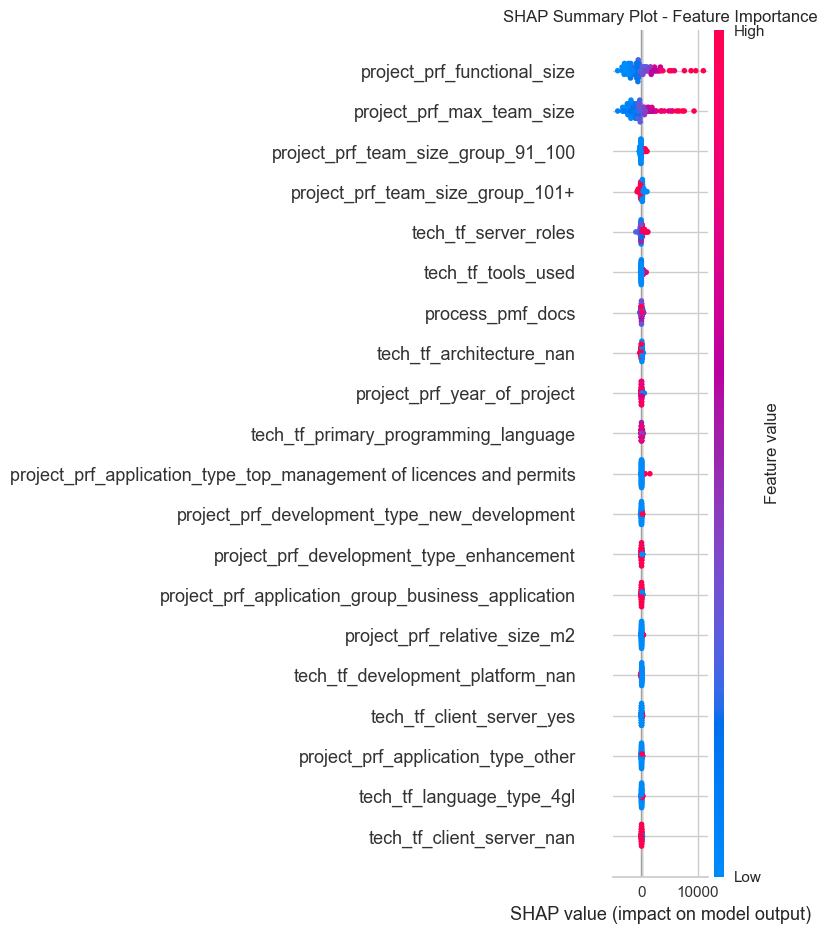

Summary plot created
Bar plot saved to: ../plots/synthetic_ISBSG2016R1_1_agile_SDV_generated_shap_importance_bar_RandomForestRegressor.png


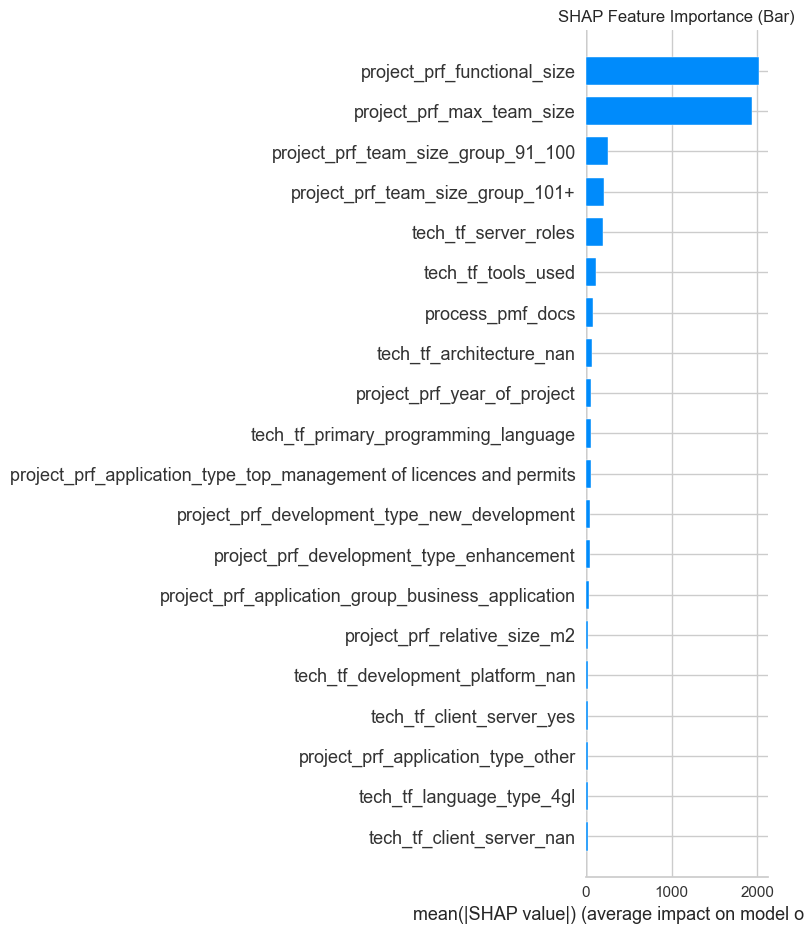

Bar plot created
Dependence plot saved to: ../plots/synthetic_ISBSG2016R1_1_agile_SDV_generated_shap_dependence_project_prf_functional_size_RandomForestRegressor.png


<Figure size 1000x600 with 0 Axes>

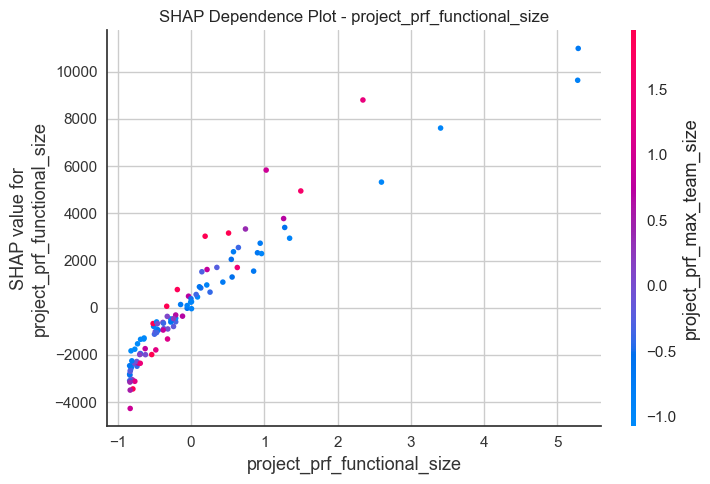

Dependence plot for 'project_prf_functional_size' created
Using modern waterfall plot...
Waterfall plot saved to: ../plots/synthetic_ISBSG2016R1_1_agile_SDV_generated_shap_waterfall_RandomForestRegressor.png


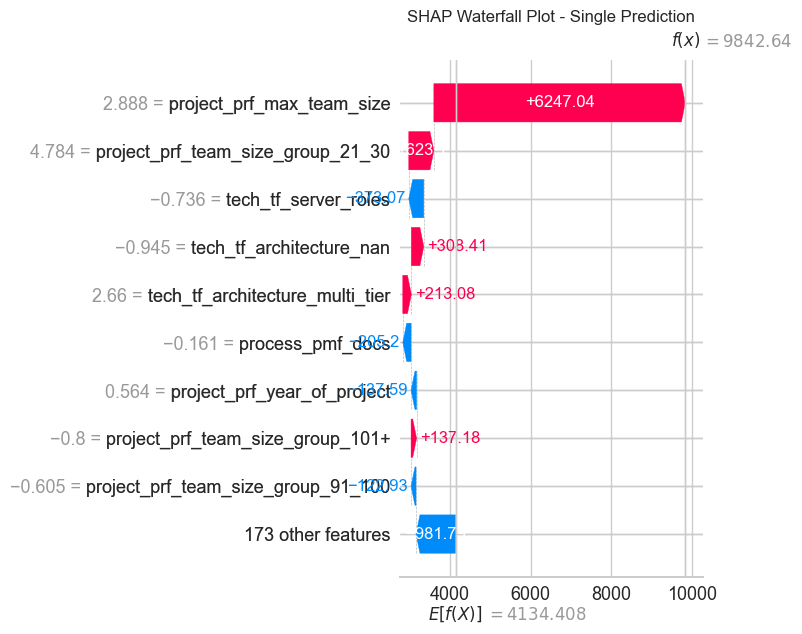

Waterfall plot created

All plots saved to folder: C:\Users\jdche\Documents\GitHub\early_agile_estimator\plots

SHAP Analysis Complete!
Cell executed at: 2025-06-03 15:05:13.201511


In [46]:
# SHAP analysis with proper data type handling and debugging
"""
Global Perspective:
- Summary Plot: Provides a global overview of feature importance and their 
  positive or negative impact on the model output across the entire dataset.
- Dependence Plot: Illustrates the relationship between a single feature's 
  value and its SHAP value across all instances to understand its general 
  effect on the prediction.
- Bar Chart: Shows the global importance of each feature based on the average 
  magnitude of their SHAP values across the entire dataset.

Single Instance Perspective:
- Force Plot: Explains the prediction for a single instance by showing how each 
  feature contributes to moving the prediction from the base value for that specific case.
- Waterfall Plot: Explains the prediction for a single instance by visualizing the sequential, 
  additive contribution of each feature's SHAP value for that specific prediction.
"""

def install_shap():
    """Install SHAP if not available"""
    try:
        import shap
        print("SHAP already installed")
        return True
    except ImportError:
        print("Installing SHAP...")
        import subprocess
        import sys
        subprocess.check_call([sys.executable, "-m", "pip", "install", "shap"])
        import shap
        print("SHAP installed successfully")
        return True

def shap_analysis(model, X_data, feature_names=None, sample_size=100, save_plots=True, plots_folder='plots'):
    """
    Simplified SHAP analysis with essential plots
    
    Parameters:
    - model: trained model
    - X_data: feature data (DataFrame or array)
    - feature_names: list of feature names (optional)
    - sample_size: number of samples for analysis (default: 100)
    - save_plots: whether to save plots to folder (default: True)
    - plots_folder: folder name to save plots (default: 'plots')
    """
    
    # Install SHAP if needed
    install_shap()
    import shap
    import os
    
    # Create plots folder if saving is enabled
    if save_plots:
        os.makedirs(plots_folder, exist_ok=True)
        print(f"Plots will be saved to: {os.path.abspath(plots_folder)}")
    
    print("Starting SHAP Analysis...")
    print(f"Data shape: {X_data.shape}")
    
    # Prepare data
    if hasattr(X_data, 'columns') and feature_names is None:
        feature_names = X_data.columns.tolist()
    elif feature_names is None:
        feature_names = [f"Feature_{i}" for i in range(X_data.shape[1])]
    
    # Sample data for efficiency
    if X_data.shape[0] > sample_size:
        sample_idx = np.random.choice(X_data.shape[0], sample_size, replace=False)
        X_sample = X_data.iloc[sample_idx] if hasattr(X_data, 'iloc') else X_data[sample_idx]
        print(f"Using {sample_size} samples for analysis")
    else:
        X_sample = X_data
    
    # Convert to float for SHAP
    try:
        X_sample = X_sample.astype(float)
    except:
        print("Could not convert to float, using original data")
    
    # Choose appropriate explainer
    model_type = str(type(model)).lower()
    print(f"Model type: {type(model).__name__}")
    
    # Track explainer type for waterfall plot handling
    explainer_type = None
    
    try:
        if any(x in model_type for x in ['tree', 'forest', 'xgboost', 'lgbm', 'catboost', 'gradient']):
            print("Using TreeExplainer")
            explainer = shap.TreeExplainer(model)
            shap_values = explainer(X_sample)
            explainer_type = 'tree'
        elif any(x in model_type for x in ['linear', 'logistic', 'ridge', 'lasso']):
            print("Using LinearExplainer")
            explainer = shap.LinearExplainer(model, X_sample)
            shap_values = explainer(X_sample)
            explainer_type = 'linear'
        else:
            print("Using Explainer (auto-detect)")
            explainer = shap.Explainer(model, X_sample)
            shap_values = explainer(X_sample)
            explainer_type = 'auto'
    except Exception as e:
        print(f"Auto-explainer failed, using KernelExplainer: {e}")
        explainer = shap.KernelExplainer(model.predict, X_sample[:10])  # Smaller background
        shap_values = explainer.shap_values(X_sample)
        explainer_type = 'kernel'
    
    # Extract SHAP values array
    shap_array = shap_values.values if hasattr(shap_values, 'values') else shap_values
    
    # Get model name for file naming
    model_name = type(model).__name__
    
    print("\n" + "="*50)
    print("SHAP PLOTS")
    print("="*50)
    
    # 1. Summary Plot (Global Feature Importance)
    try:
        plt.figure(figsize=(10, 6))
        shap.summary_plot(shap_array, X_sample, feature_names=feature_names, show=False)
        plt.title("SHAP Summary Plot - Feature Importance")
        plt.tight_layout()
        if save_plots:
            summary_path = f'{plots_folder}/shap_summary_{model_name}.png'
            plt.savefig(summary_path, dpi=300, bbox_inches='tight')
            print(f"Summary plot saved to: {summary_path}")
        plt.show()
        print("Summary plot created")
    except Exception as e:
        print(f"Summary plot failed: {e}")
    
    # 2. Bar Plot (Feature Importance)
    try:
        plt.figure(figsize=(10, 6))
        shap.summary_plot(shap_array, X_sample, feature_names=feature_names, 
                         plot_type="bar", show=False)
        plt.title("SHAP Feature Importance (Bar)")
        plt.tight_layout()
        if save_plots:
            bar_path = f'{plots_folder}/{file_name_no_ext}_shap_importance_bar_{model_name}.png'
            plt.savefig(bar_path, dpi=300, bbox_inches='tight')
            print(f"Bar plot saved to: {bar_path}")
        plt.show()
        print("Bar plot created")
    except Exception as e:
        print(f"Bar plot failed: {e}")
    
    # 3. Dependence Plot for top feature
    try:
        # Find most important feature
        mean_shap = np.abs(shap_array).mean(0)
        top_feature_idx = np.argmax(mean_shap)
        top_feature = feature_names[top_feature_idx]
        
        plt.figure(figsize=(10, 6))
        shap.dependence_plot(top_feature_idx, shap_array, X_sample, 
                           feature_names=feature_names, show=False)
        plt.title(f"SHAP Dependence Plot - {top_feature}")
        plt.tight_layout()
        if save_plots:
            dep_path = f'{plots_folder}/{file_name_no_ext}_shap_dependence_{top_feature}_{model_name}.png'
            plt.savefig(dep_path, dpi=300, bbox_inches='tight')
            print(f"Dependence plot saved to: {dep_path}")
        plt.show()
        print(f"Dependence plot for '{top_feature}' created")
    except Exception as e:
        print(f"Dependence plot failed: {e}")
    
    # 4. Waterfall Plot for first instance - FIXED VERSION
    try:
        plt.figure(figsize=(10, 6))
        
        if explainer_type == 'kernel':
            # For KernelExplainer, create proper Explanation object
            print("Creating waterfall plot for KernelExplainer...")
            
            # Get the first instance data
            first_instance = X_sample.iloc[0] if hasattr(X_sample, 'iloc') else X_sample[0]
            first_shap = shap_array[0]
            
            # Create Explanation object manually
            explanation = shap.Explanation(
                values=first_shap,
                base_values=explainer.expected_value,
                data=first_instance,
                feature_names=feature_names
            )
            
            shap.plots.waterfall(explanation, show=False)
            
        elif hasattr(shap_values, '__getitem__') and hasattr(shap_values, 'base_values'):
            # For newer SHAP versions with Explanation objects
            print("Using modern waterfall plot...")
            shap.plots.waterfall(shap_values[0], show=False)
            
        else:
            # Fallback for older versions or different explainer types
            print("Using legacy waterfall plot...")
            base_val = getattr(explainer, 'expected_value', 0)
            if hasattr(base_val, '__getitem__'):
                base_val = base_val[0] if len(base_val) > 0 else 0
                
            first_instance = X_sample.iloc[0] if hasattr(X_sample, 'iloc') else X_sample[0]
            
            shap.waterfall_plot(
                base_val, 
                shap_array[0], 
                first_instance,
                feature_names=feature_names,
                show=False
            )
        
        plt.title("SHAP Waterfall Plot - Single Prediction")
        plt.tight_layout()
        if save_plots:
            waterfall_path = f'{plots_folder}/{file_name_no_ext}_shap_waterfall_{model_name}.png'
            plt.savefig(waterfall_path, dpi=300, bbox_inches='tight')
            print(f"Waterfall plot saved to: {waterfall_path}")
        plt.show()
        print("Waterfall plot created")
        
    except Exception as e:
        print(f"Waterfall plot failed: {e}")
        # Alternative: Force plot as backup
        try:
            print("Attempting force plot as alternative...")
            plt.figure(figsize=(12, 4))
            base_val = getattr(explainer, 'expected_value', 0)
            if hasattr(base_val, '__getitem__'):
                base_val = base_val[0] if len(base_val) > 0 else 0
            
            first_instance = X_sample.iloc[0] if hasattr(X_sample, 'iloc') else X_sample[0]
            shap.force_plot(base_val, shap_array[0], first_instance, 
                           feature_names=feature_names, matplotlib=True, show=False)
            plt.title("SHAP Force Plot - Single Prediction (Alternative)")
            if save_plots:
                force_path = f'{plots_folder}/{file_name_no_ext}_shap_force_{model_name}.png'
                plt.savefig(force_path, dpi=300, bbox_inches='tight')
                print(f"Force plot saved to: {force_path}")
            plt.show()
            print("Force plot created as alternative")
        except Exception as e2:
            print(f"Both waterfall and force plots failed: {e2}")
    
    if save_plots:
        print(f"\nAll plots saved to folder: {os.path.abspath(plots_folder)}")
    print("\nSHAP Analysis Complete!")
    return shap_values, explainer

# Quick function for single model analysis
def quick_shap(model, X_data, y_data=None, save_plots=True):
    """
    Ultra-simple SHAP analysis - just pass your model and data
    """
    print("Quick SHAP Analysis")
    return shap_analysis(model, X_data, save_plots=save_plots)


# -------- RUN SHAP FOR ALL TUNED MODELS --------

# For a single model (saves plots by default):
#shap_values, explainer = quick_shap(your_model, X_test)

# Without saving plots:
#shap_analysis(your_model, X_test, save_plots=False)

# Custom plots folder:
#shap_analysis(your_model, X_test, plots_folder='my_shap_plots')

# For multiple models:
#models = [model1, model2, model3]  # Your list of models
#for i, model in enumerate(models, 1):
#    print(f"\n{'='*20} MODEL {i} {'='*20}")
#    shap_analysis(model, X_test, sample_size=50, plots_folder=f'plots/model_{i}')

# With PyCaret:
from pycaret.regression import get_config
X_transformed = get_config('X_transformed')

for idx, tuned_model in enumerate(tuned_models, 1):
    print(f"\n{'='*20} MODEL {idx} {'='*20}")
    shap_analysis(tuned_model, X_transformed, plots_folder=plots_folder)


# Function to check what plots were saved
def check_saved_plots(plots_folder=plots_folder):
    """Check what SHAP plots were saved in the folder"""
    import os
    if os.path.exists(plots_folder):
        files = [f for f in os.listdir(plots_folder) if f.endswith('.png')]
        if files:
            print(f"Found {len(files)} SHAP plots in '{plots_folder}':")
            for file in sorted(files):
                print(f"  - {file}")
        else:
            print(f"No plot files found in '{plots_folder}'")
    else:
        print(f"Folder '{plots_folder}' does not exist")

In [47]:
# Extract feature importance directly (if available)
# Feature Importance Extraction - Refined Version
"""
Extract and analyze built-in feature importance from trained models.
This provides quick numerical insights into which features each model considers most important.

Supports:
- Tree-based models: feature_importances_ attribute
- Linear models: coef_ attribute (absolute values)
- Saves results as CSV files for further analysis
"""

def extract_feature_importance(tuned_models, data_folder='feature_analysis', top_n=15):
    """
    Extract built-in feature importance from models
    
    Parameters:
    - tuned_models: list of trained models
    - data_folder: folder to save CSV files (default: 'feature_analysis')
    - top_n: number of top features to display (default: 15)
    """
    
    print("="*60)
    print("FEATURE IMPORTANCE EXTRACTION")
    print("="*60)
    
    from pycaret.regression import get_config
    
    # Create output directory
    os.makedirs(data_folder, exist_ok=True)
    print(f"Feature importance files will be saved to: {os.path.abspath(data_folder)}")
    
    # Get feature names from transformed data
    try:
        feature_names = get_config('X_transformed').columns
        print(f"Total features available: {len(feature_names)}")
    except Exception as e:
        print(f"Could not get feature names from PyCaret config: {e}")
        return
    
    successful_extractions = 0
    
    for idx, tuned_model in enumerate(tuned_models, 1):
        model_name = type(tuned_model).__name__
        print(f"\n{'-'*40}")
        print(f"Model {idx}: {model_name}")
        print(f"{'-'*40}")
        
        try:
            # Determine importance extraction method
            if hasattr(tuned_model, 'feature_importances_'):
                importances = tuned_model.feature_importances_
                importance_label = 'feature_importances_'
                print(f"✓ Using {importance_label} attribute")
                
            elif hasattr(tuned_model, 'coef_'):
                # For linear models, use absolute coefficients
                coef = tuned_model.coef_
                # Handle multi-output case
                if coef.ndim > 1:
                    importances = np.abs(coef).mean(axis=0)
                else:
                    importances = np.abs(coef)
                importance_label = 'coef_ (absolute values)'
                print(f"✓ Using {importance_label}")
                
            else:
                print(f"✗ Feature importance attribute not available for {model_name}")
                print("  Supported attributes: feature_importances_, coef_")
                continue
            
            # Validate lengths match
            if len(feature_names) != len(importances):
                print(f"⚠ Warning: Length mismatch detected!")
                print(f"  Features: {len(feature_names)}, Importances: {len(importances)}")
                min_length = min(len(feature_names), len(importances))
                feature_names_adj = feature_names[:min_length]
                importances_adj = importances[:min_length]
                print(f"  Using first {min_length} elements for both")
            else:
                feature_names_adj = feature_names
                importances_adj = importances
                print(f"✓ Lengths match: {len(feature_names_adj)} features")
            
            # Create feature importance DataFrame
            fi_df = pd.DataFrame({
                'feature': feature_names_adj,
                'importance': importances_adj,
                'model': model_name,
                'importance_type': importance_label
            })
            
            # Sort by importance (descending)
            fi_df = fi_df.sort_values('importance', ascending=False).reset_index(drop=True)
            
            # Add rank
            fi_df['rank'] = range(1, len(fi_df) + 1)
            
            # Display top features
            print(f"\nTop {min(top_n, len(fi_df))} Most Important Features:")
            display_df = fi_df[['rank', 'feature', 'importance']].head(top_n)
            print(display_df.to_string(index=False, float_format='{:.6f}'.format))
            
            # Save to CSV
            output_filename = f"{file_name_no_ext}_feature_importance_model_{idx}_{model_name}.csv"
            output_path = os.path.join(data_folder, output_filename)
            fi_df.to_csv(output_path, index=False)
            
            print(f"✓ Feature importance saved to: '{output_path}'")
            print(f"  Rows saved: {len(fi_df)}")
            print(f"  Importance type: {importance_label}")
            
            successful_extractions += 1
            
        except Exception as e:
            print(f"✗ Failed to extract feature importance for {model_name}")
            print(f"  Error: {str(e)}")
            continue
    
    # Summary
    print(f"\n{'='*60}")
    print("EXTRACTION SUMMARY")
    print(f"{'='*60}")
    print(f"Total models processed: {len(tuned_models)}")
    print(f"Successful extractions: {successful_extractions}")
    print(f"Failed extractions: {len(tuned_models) - successful_extractions}")
    print(f"Output folder: {os.path.abspath(data_folder)}")
    
    return successful_extractions

def compare_feature_importance(data_folder='feature_analysis', top_n=10):
    """
    Compare feature importance across all saved models
    
    Parameters:
    - data_folder: folder containing feature importance CSV files
    - top_n: number of top features to compare
    """
    
    print(f"\n{'='*60}")
    print("FEATURE IMPORTANCE COMPARISON")
    print(f"{'='*60}")
    
    # Find all feature importance files
    if not os.path.exists(data_folder):
        print(f"Folder '{data_folder}' does not exist")
        return
    
    csv_files = [f for f in os.listdir(data_folder) if f.startswith('feature_importance_') and f.endswith('.csv')]
    
    if not csv_files:
        print(f"No feature importance files found in '{data_folder}'")
        return
    
    print(f"Found {len(csv_files)} feature importance files")
    
    # Load and combine all results
    all_importance = []
    
    for file in csv_files:
        file_path = os.path.join(data_folder, file)
        try:
            df = pd.read_csv(file_path)
            all_importance.append(df)
            print(f"✓ Loaded: {file}")
        except Exception as e:
            print(f"✗ Failed to load {file}: {e}")
    
    if not all_importance:
        print("No files could be loaded")
        return
    
    # Combine all DataFrames
    combined_df = pd.concat(all_importance, ignore_index=True)
    
    # Create pivot table for comparison
    pivot_df = combined_df.pivot_table(
        index='feature', 
        columns='model', 
        values='importance', 
        fill_value=0
    )
    
    # Calculate average importance across models
    pivot_df['avg_importance'] = pivot_df.mean(axis=1)
    pivot_df = pivot_df.sort_values('avg_importance', ascending=False)
    
    # Display top features comparison
    print(f"\nTop {top_n} Features - Comparison Across Models:")
    print("-" * 80)
    comparison_df = pivot_df.head(top_n)
    print(comparison_df.to_string(float_format='{:.6f}'.format))
    
    # Save comparison
    comparison_path = os.path.join(data_folder, '{file_name_no_ext}_feature_importance_comparison.csv')
    pivot_df.to_csv(comparison_path)
    print(f"\n✓ Comparison saved to: '{comparison_path}'")
    
    return pivot_df

def check_saved_importance(data_folder='feature_analysis'):
    """Check what feature importance files were saved"""
    
    print(f"\n{'='*60}")
    print("SAVED FEATURE IMPORTANCE FILES")
    print(f"{'='*60}")
    
    if not os.path.exists(data_folder):
        print(f"Folder '{data_folder}' does not exist")
        return
    
    csv_files = [f for f in os.listdir(data_folder) if f.endswith('.csv')]
    
    if csv_files:
        print(f"Found {len(csv_files)} CSV files in '{data_folder}':")
        for i, file in enumerate(sorted(csv_files), 1):
            file_path = os.path.join(data_folder, file)
            try:
                df = pd.read_csv(file_path)
                print(f"  {i}. {file} ({len(df)} features)")
            except:
                print(f"  {i}. {file} (could not read)")
    else:
        print(f"No CSV files found in '{data_folder}'")

# -------- USAGE EXAMPLES --------

# Basic usage with your tuned models:
# extract_feature_importance(tuned_models)

# Custom settings:
# extract_feature_importance(tuned_models, data_folder='my_analysis', top_n=20)

# Compare results across models:
# compare_feature_importance()

# Check what files were saved:
# check_saved_importance()

# -------- MAIN EXECUTION --------
# Uncomment to run with your models:


# Run feature importance extraction
successful = extract_feature_importance(tuned_models, data_folder=data_folder, top_n=15)

if successful > 0:
    # Compare importance across models
    comparison_df = compare_feature_importance(data_folder=data_folder, top_n=10)
    
    # Show saved files
    check_saved_importance(data_folder=data_folder)
else:
    print("No feature importance could be extracted from any model")


FEATURE IMPORTANCE EXTRACTION
Feature importance files will be saved to: C:\Users\jdche\Documents\GitHub\early_agile_estimator\data
Total features available: 182

----------------------------------------
Model 1: GradientBoostingRegressor
----------------------------------------
✓ Using feature_importances_ attribute
✓ Lengths match: 182 features

Top 15 Most Important Features:
 rank                                                             feature  importance
    1                                         project_prf_functional_size    0.460556
    2                                           project_prf_max_team_size    0.381440
    3                                  project_prf_team_size_group_91_100    0.030619
    4                                                tech_tf_server_roles    0.027269
    5                                    project_prf_team_size_group_101+    0.017633
    6                                         project_prf_relative_size_s    0.006103
    7           

In [48]:
#verifying whether the trained model consider target column as input features

print(f"TARGET_COL value: {TARGET_COL}")


csv_features = pd.read_csv(f"{data_folder}/pycaret_processed_features_before_model_training.csv")
print("Features in CSV file:")
print(csv_features.columns.tolist())
print(f"\nDoes CSV contain target column? {'project_prf_normalised_work_effort' in csv_features.columns}")


for i, tuned_model in enumerate(tuned_models, 1):
    model_name = type(tuned_model).__name__
    print(f"\nModel {i}: {model_name}")
    
    # For PyCaret models, try different ways to get feature names
    if hasattr(tuned_model, 'feature_names_in_'):
        features = tuned_model.feature_names_in_
    elif hasattr(tuned_model, 'feature_names_'):
        features = tuned_model.feature_names_
    else:
        # Try to get from the pipeline
        try:
            features = tuned_model[:-1].get_feature_names_out()
        except:
            features = "Could not determine features"
    
    print(f"\n{model_name} expected features:")
    print(features)
    print(f"\nDoes CSV contain target column? {'project_prf_normalised_work_effort' in features}")

TARGET_COL value: project_prf_normalised_work_effort
Features in CSV file:
['project_prf_year_of_project', 'external_eef_industry_sector', 'tech_tf_primary_programming_language', 'project_prf_functional_size', 'project_prf_team_size_group', 'project_prf_max_team_size', 'process_pmf_development_methodologies', 'process_pmf_docs', 'tech_tf_client_roles', 'tech_tf_server_roles', 'tech_tf_tools_used', 'project_prf_application_group_business_application', 'project_prf_application_group_infrastructure_software', 'project_prf_application_group_mathematically_intensive_application', 'project_prf_application_group_nan', 'project_prf_application_group_real_time_application', 'tech_tf_clientserver_description_browser_server_architecture', 'tech_tf_clientserver_description_client_server', 'tech_tf_clientserver_description_client_presentation', 'tech_tf_clientserver_description_client_presentation_processing', 'tech_tf_clientserver_description_client_server_architecture', 'tech_tf_clientserver_desc